# A STUDY OF THE USE OF COLOUR THROUGH SPACE


## DO THE COUNTRY AND CITY OF ORIGIN OF ARTIST INFLUENCE THEIR USE OF COLOUR ?

CASA0006: Data Science for Spatial Systems

Word count: 3053 words

Total run time: about 40 minutes

## INTRODUCTION

Since the earliest traces of art on the walls of Indonesian caves 30000 years ago, to the works of modern artists, colour has always played an essential part in how people express themselves through art. However, the use of different colours in artworks and everyday items has evolved with technical progress and cultural evolutions: prehistoric paintings were produced with earth pigments and water, the Egyptians discovered greens and blues from mineral pigments, other colours were introduced in Greece, China... (Mather, 2013). Recently, further progress permits to delve even further in the development of colour theory, with the creation of new pigments such as vantablack (Ball, 2016). 


Initially, a major role of art was to recreate nature, and colours brought art closer to nature. Specific theories of colour taught to artists are considered essential to the technical skill set of artists. Recently, with the development and progress of photography, art has lost its representational aspect. Still, colour has remained essential in art, with many 20th century artists being considered masters of colour theory (Best, 2017). 


So, despite the evolution of the purpose and status of art, colour has remained a major element in artistic production. But what is the impact of artists’ backgrounds on the colours used in artworks? As different pigments were created in different countries at different times, and as the initial purpose was to reproduce the nature surrounding the artist, then it appears obvious that artists from different regions use colours differently. 


Cross-regional studies of the emotional impact of colours reveal cultural differences in the way people perceive and interpret colours (Adams, 1973). Although these studies are often applied to fields such as marketing, they reveal the strong difference between countries when considering colour perception. 


How are those cultural preferences and influences reflected in art? 

This project therefore aims at exploring whether the use of specific colours can be linked to the country and city of origin of the artist that produced them. In order to do so, the database from the TATE collections was selected (Tate, 2014). This dataset contains information about the artworks purchased by the TATE until 2014, as well as data about the artists who produced these artworks. This notebook first analyses the initial data provided about the TATE collections and processes this data in order to obtain the colour distribution of each painting in the dataset. Additional preprocessing is also undertaken to obtain a final dataset that can be analysed. Initial observations are presented as well as some limitations of the dataset and methodology adopted. The analysis methodology is then presented. The results of the analysis are eventually discussed, and suggestions for future research are made from the limitations observed.

Note: The parts of the code that computed the colour distribution of each image took up to 20 hours. Additionally, this computation required downloading all the images of the dataset (done here in a folder called img), taking up 351 MB. The results of these algorithms were therefore saved in csv files so as to avoid repeating this process, and thus do not need to be run again. They have been commented out in this notebook, but can be run again if desired. 

## INTIAL DATA

The data selected is taken from the TATE collections online database. The data is separated into two tables: the artwork table and the artist table. The artwork tables contain information about the artworks purchased by the TATE, such as title, artist, medium, year purchased, link to a thumbnail of the artwork picture, dimensions and description. The artist table contains information regarding the artists’ date of birth and death is applicable, place of birth and death if applicable, as well as a link to the description of the artist on the TATE website. 
The two datasets are first imported to the notebook and some initial observations are made. 

Firstly, the libraries used in this analysis are imported. The datasets are then read, explored and processed in view of the analysis. 

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
import urllib
import numpy as np
import os
import sklearn.preprocessing as preprocessing
from sklearn.cluster import DBSCAN
from shapely.geometry import Point
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
import random

In [2]:
artworks = pd.read_csv('artwork_data.csv', na_filter=False)

C:\Users\margo\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### INITIAL OBSERVATIONS AND DATA CLEANING

Before starting the analysis, some cleaning, preprocessing and observations need to be done.

In [3]:
for col in artworks.columns:
    print('\n')
    print(artworks[[col]].describe())



                  id
count   69201.000000
mean    39148.026213
std     25980.468687
min         3.000000
25%     19096.000000
50%     37339.000000
75%     54712.000000
max    129068.000000


       accession_number
count             69201
unique            69201
top              T00358
freq                  1


                                artist
count                            69201
unique                            3336
top     Turner, Joseph Mallord William
freq                             39389


       artistRole
count       69201
unique         19
top        artist
freq        66907


           artistId
count  69201.000000
mean    1201.063251
std     2019.422535
min        0.000000
25%      558.000000
50%      558.000000
75%     1137.000000
max    19232.000000


                    title
count               69201
unique              43531
top     [title not known]
freq                 3572


              dateText
count            69201
unique            2736
top     date 

In [4]:
artworks_w_years = artworks.loc[artworks['year']!='']
artworks_w_years = artworks_w_years.loc[(artworks_w_years['year']!='no date')&(artworks_w_years['year']!='c.1997-9')]
artworks_w_years

id accession_number              artist artistRole  artistId  \
2        1037           A00003       Blake, Robert     artist        38   
4        1039           A00005      Blake, William     artist        39   
5        1040           A00006      Blake, William     artist        39   
6        1041           A00007      Blake, William     artist        39   
7        1042           A00008      Blake, William     artist        39   
...       ...              ...                 ...        ...       ...   
69196  122960           T13865  P-Orridge, Genesis     artist     16646   
69197  122961           T13866  P-Orridge, Genesis     artist     16646   
69198  121181           T13867        Hatoum, Mona     artist      2365   
69199  112306           T13868       Creed, Martin     artist      2760   
69200  127035           T13869   Brunias, Agostino     artist      3824   

                                                   title  \
2      The Preaching of Warning. Verso: An Old Man En...   
4      The Circle of the Lustful: Francesca da Rimini...   
5          Ciampolo the Barrator Tormented by the Devils   
6                            The Baffled Devils Fighting   
7      The Six-Footed Serpent Attacking Agnolo Brunel...   
...                                                  ...   
69196                        Larvae (from Tampax Romana)   
69197                   Living Womb (from Tampax Romana)   
69198                                      Present Tense   
69199          Work No. 227: The lights going on and off   
69200                   Dancing Scene in the West Indies   

                     dateText  \
2                     ?c.1785   
4      1826–7, reprinted 1892   
5      1826–7, reprinted 1892   
6      1826–7, reprinted 1892   
7      1826–7, reprinted 1892   
...                       ...   
69196                    1975   
69197                    1976   
69198                    1996   
69199                    2000   
69200                 1764–96   

                                                  medium  \
2            Graphite on paper. Verso: graphite on paper   
4                                Line engraving on paper   
5                                Line engraving on paper   
6                                Line engraving on paper   
7                                Line engraving on paper   
...                                                  ...   
69196   Perspex, Wood, hairpiece, tampon and human blood   
69197  Wood, Perspex, plastic, photograph on paper, t...   
69198                               Soap and glass beads   
69199                                   Gallery lighting   
69200                                Oil paint on canvas   

                                              creditLine  year  \
2                    Presented by Mrs John Richmond 1922  1785   
4      Purchased with the assistance of a special gra...  1826   
5      Purchased with the assistance of a special gra...  1826   
6      Purchased with the assistance of a special gra...  1826   
7      Purchased with the assistance of a special gra...  1826   
...                                                  ...   ...   
69196                 Transferred from Tate Archive 2012  1975   
69197                 Transferred from Tate Archive 2012  1976   
69198                     Presented by Tate Members 2013  1996   
69199  Purchased with funds provided by Tate Members,...  2000   
69200  Purchased with assistance from Tate Patrons an...  1764   

      acquisitionYear                           dimensions width height depth  \
2                1922                support: 343 x 467 mm   343    467         
4                1919                  image: 243 x 335 mm   243    335         
5                1919                  image: 240 x 338 mm   240    338         
6                1919                  image: 242 x 334 mm   242    334         
7                1919                  image: 246 x 340 mm   246    340  

In [5]:
years = set(artworks_w_years['year'])

In [6]:
years = sorted(list(years))

In [7]:
art_per_year = artworks_w_years.groupby('year').count()

As the TATE collection does not include artworks produced every year, some years have no associated value. In order to print a figure with a coherent x-axis, these years need to be associated with a null value, so that even the years with no paintings are represented.

In [8]:
nb_per_year = {}
for year in years:
    nb_per_year[year] = artworks.loc[artworks['year'] == str(year)].shape[0]
print(nb_per_year)

{'1545': 2, '1557': 1, '1563': 1, '1565': 1, '1569': 1, '1573': 2, '1576': 1, '1586': 1, '1592': 1, '1594': 1, '1595': 1, '1596': 2, '1600': 1, '1605': 1, '1610': 1, '1615': 3, '1619': 1, '1620': 5, '1623': 1, '1625': 2, '1628': 1, '1629': 2, '1630': 1, '1633': 1, '1635': 2, '1636': 2, '1637': 1, '1638': 2, '1639': 1, '1640': 1, '1642': 1, '1644': 2, '1645': 1, '1646': 2, '1647': 1, '1648': 2, '1650': 2, '1654': 1, '1655': 2, '1658': 1, '1659': 1, '1660': 6, '1661': 2, '1662': 1, '1670': 5, '1672': 1, '1674': 1, '1675': 1, '1676': 1, '1679': 1, '1680': 5, '1681': 1, '1683': 2, '1684': 1, '1685': 2, '1689': 1, '1690': 3, '1692': 1, '1695': 2, '1696': 3, '1699': 2, '1700': 2, '1701': 1, '1707': 1, '1710': 5, '1713': 1, '1715': 3, '1716': 1, '1718': 1, '1719': 1, '1720': 6, '1721': 1, '1723': 1, '1724': 1, '1725': 3, '1726': 1, '1728': 3, '1730': 5, '1731': 3, '1732': 2, '1733': 9, '1734': 3, '1735': 10, '1736': 1, '1737': 3, '1738': 4, '1739': 2, '1740': 13, '1741': 4, '1742': 3, '1743':

In [9]:
years_in_df = art_per_year[['id']].to_dict('index')
final_art_per_year = {}
year = int(art_per_year.index[0])
while year<= int(art_per_year.index[-1]):
    if str(year) not in years_in_df.keys():
        final_art_per_year[year] = np.nan
    else: 
        final_art_per_year[year] = years_in_df[str(year)]['id']
    year+=1
final_art_per_year

{1545: 2,
 1546: nan,
 1547: nan,
 1548: nan,
 1549: nan,
 1550: nan,
 1551: nan,
 1552: nan,
 1553: nan,
 1554: nan,
 1555: nan,
 1556: nan,
 1557: 1,
 1558: nan,
 1559: nan,
 1560: nan,
 1561: nan,
 1562: nan,
 1563: 1,
 1564: nan,
 1565: 1,
 1566: nan,
 1567: nan,
 1568: nan,
 1569: 1,
 1570: nan,
 1571: nan,
 1572: nan,
 1573: 2,
 1574: nan,
 1575: nan,
 1576: 1,
 1577: nan,
 1578: nan,
 1579: nan,
 1580: nan,
 1581: nan,
 1582: nan,
 1583: nan,
 1584: nan,
 1585: nan,
 1586: 1,
 1587: nan,
 1588: nan,
 1589: nan,
 1590: nan,
 1591: nan,
 1592: 1,
 1593: nan,
 1594: 1,
 1595: 1,
 1596: 2,
 1597: nan,
 1598: nan,
 1599: nan,
 1600: 1,
 1601: nan,
 1602: nan,
 1603: nan,
 1604: nan,
 1605: 1,
 1606: nan,
 1607: nan,
 1608: nan,
 1609: nan,
 1610: 1,
 1611: nan,
 1612: nan,
 1613: nan,
 1614: nan,
 1615: 3,
 1616: nan,
 1617: nan,
 1618: nan,
 1619: 1,
 1620: 5,
 1621: nan,
 1622: nan,
 1623: 1,
 1624: nan,
 1625: 2,
 1626: nan,
 1627: nan,
 1628: 1,
 1629: 2,
 1630: 1,
 1631: nan,
 1

Firstly, upon looking at the year of creation of the artworks in the TATE collection, it appears that most of the artworks purchased by the TATE were produced between 1800 and 1850. Beside this, many artworks in the TATE collection have been created between 1950 and 2000. It can therefore be assumed that, as most artworks included in this study were produced within a 100-year timespan (between 1800 and 1850 and 1950 and 2000), that the study will be skewed and will not accurately represent trends that may have merged in years between these two periods. 


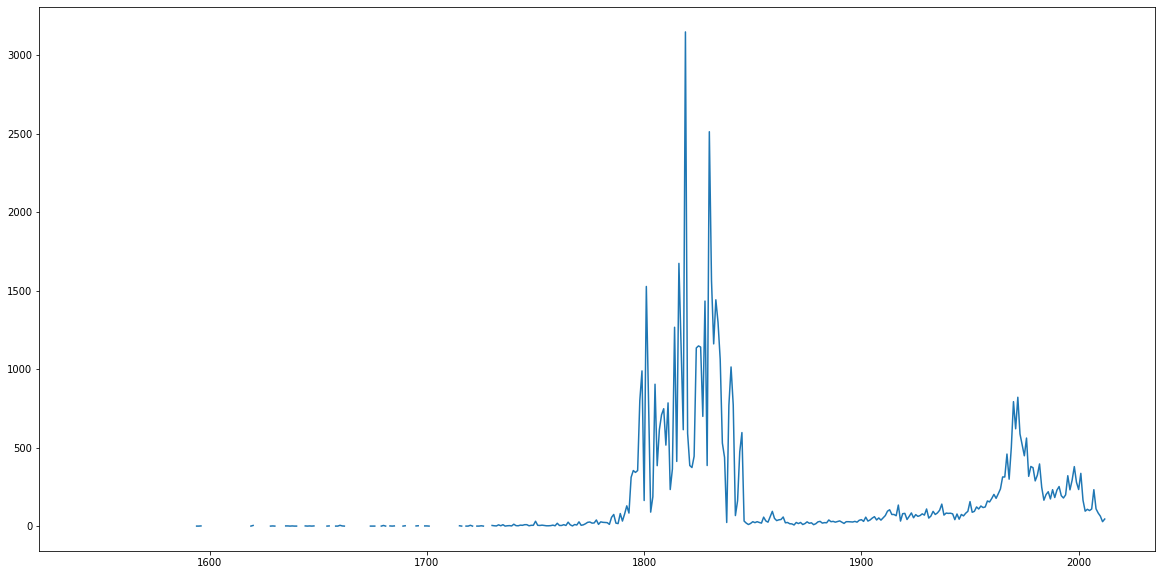

In [10]:
fig = plt.figure(figsize = [20,10])
ax = fig.subplots()
ax.plot(*zip(*sorted(final_art_per_year.items())))
plt.show()

In [11]:
artists = pd.read_csv('artist_data.csv', na_filter= False)
artists.head()

id                    name  gender      dates yearOfBirth yearOfDeath  \
0  10093  Abakanowicz, Magdalena  Female  born 1930        1930               
1      0     Abbey, Edwin Austin    Male  1852–1911        1852        1911   
2   2756        Abbott, Berenice  Female  1898–1991        1898        1991   
3      1  Abbott, Lemuel Francis    Male  1760–1803        1760        1803   
4    622          Abrahams, Ivor    Male  born 1935        1935               

                     placeOfBirth            placeOfDeath  \
0                          Polska                           
1     Philadelphia, United States  London, United Kingdom   
2      Springfield, United States   Monson, United States   
3  Leicestershire, United Kingdom  London, United Kingdom   
4           Wigan, United Kingdom                           

                                                 url  
0  http://www.tate.org.uk/art/artists/magdalena-a...  
1  http://www.tate.org.uk/art/artists/edwin-austi...  
2  http://www.tate.org.uk/art/artists/berenice-ab...  
3  http://www.tate.org.uk/art/artists/lemuel-fran...  
4  http://www.tate.org.uk/art/artists/ivor-abraha...

In order to get a better view of the place of origin of the artists, the column containing information regarding place of birth needs to be cleaned. The data contained in this column appears to take two forms: either the place of birth is simply the country of origin of the artists, or the city and country are provided, separated by a comma. This column is thus split in two: the country of birth column which takes the value of the single word specified, or of the word after the comma if both city and country are provided. The city of birth table is filled with either the first word before the comma, or with ‘unknown’ if no city is provided. 


Some country names appear to be in the local language, thus potentially rendering more complex the understanding and plotting of the data. Therefore, the column needs to be normalised. However, as some rows need to be deleted when cleaning the data, the normalisation should be done last to prevent doing work on data that is not present in the final dataset.


In [12]:
new = artists["placeOfBirth"].str.split(", ", n = 1, expand = True) 
columns_to_add = {"countryOfBirth" : [], "cityOfBirth" : []}
for i in range(artists.shape[0]):
    print(new.iloc[i,:])
    if new.iloc[i, 1] == None:
        columns_to_add['cityOfBirth'].append('Unknown')
        columns_to_add['countryOfBirth'].append(new.iloc[i, 0])
    else:
        columns_to_add['cityOfBirth'].append(new.iloc[i, 0])
        columns_to_add['countryOfBirth'].append(new.iloc[i, 1])

artists['cityOfBirth']=columns_to_add['cityOfBirth']
artists['countryOfBirth']=columns_to_add['countryOfBirth']
artists

0    Polska
1      None
Name: 0, dtype: object
0     Philadelphia
1    United States
Name: 1, dtype: object
0      Springfield
1    United States
Name: 2, dtype: object
0    Leicestershire
1    United Kingdom
Name: 3, dtype: object
0             Wigan
1    United Kingdom
Name: 4, dtype: object
0    Tel Aviv-Yafo
1         Yisra'el
Name: 5, dtype: object
0           Kiel
1    Deutschland
Name: 6, dtype: object
0         New York
1    United States
Name: 7, dtype: object
0         Isleworth
1    United Kingdom
Name: 8, dtype: object
0             Leeds
1    United Kingdom
Name: 9, dtype: object
0         Kirkcaldy
1    United Kingdom
Name: 10, dtype: object
0         Worcester
1    United Kingdom
Name: 11, dtype: object
0            London
1    United Kingdom
Name: 12, dtype: object
0       Northampton
1    United Kingdom
Name: 13, dtype: object
0            London
1    United Kingdom
Name: 14, dtype: object
0    Tuszyn
1    Polska
Name: 15, dtype: object
0            London
1    United 

Name: 180, dtype: object
0      ‘Afula
1    Yisra'el
Name: 181, dtype: object
0         Berlin
1    Deutschland
Name: 182, dtype: object
0       Long Beach
1    United States
Name: 183, dtype: object
0    Firenze
1     Italia
Name: 184, dtype: object
0    São Paulo
1       Brasil
Name: 185, dtype: object
0        Sachsen
1    Deutschland
Name: 186, dtype: object
0    New Brunswick
1    United States
Name: 187, dtype: object
0            Dundee
1    United Kingdom
Name: 188, dtype: object
0        
1    None
Name: 189, dtype: object
0            Kendal
1    United Kingdom
Name: 190, dtype: object
0         Stevenage
1    United Kingdom
Name: 191, dtype: object
0    Calgary
1     Canada
Name: 192, dtype: object
0    United Kingdom
1              None
Name: 193, dtype: object
0    Château-Renault
1             France
Name: 194, dtype: object
0    s Gravenhage
1       Nederland
Name: 195, dtype: object
0      Stuttgart
1    Deutschland
Name: 196, dtype: object
0     Rheinsberg
1    Deutsch

Name: 322, dtype: object
0    Figline Valdarno
1              Italia
Name: 323, dtype: object
0            Arnold
1    United Kingdom
Name: 324, dtype: object
0    Fontenay-aux-Roses
1                France
Name: 325, dtype: object
0       Providence
1    United States
Name: 326, dtype: object
0        
1    None
Name: 327, dtype: object
0            Darvel
1    United Kingdom
Name: 328, dtype: object
0    Ceská Republika
1               None
Name: 329, dtype: object
0           Boston
1    United States
Name: 330, dtype: object
0        
1    None
Name: 331, dtype: object
0        Portsmouth
1    United Kingdom
Name: 332, dtype: object
0    Madras
1    Bharat
Name: 333, dtype: object
0       Westport
1    New Zealand
Name: 334, dtype: object
0            Surrey
1    United Kingdom
Name: 335, dtype: object
0          Carlisle
1    United Kingdom
Name: 336, dtype: object
0           Norwich
1    United Kingdom
Name: 337, dtype: object
0     Deventer
1    Nederland
Name: 338, dtype: obje

Name: 480, dtype: object
0       Louisville
1    United States
Name: 481, dtype: object
0    Québec
1    Canada
Name: 482, dtype: object
0           Chester
1    United Kingdom
Name: 483, dtype: object
0     Philadelphia
1    United States
Name: 484, dtype: object
0    Poitiers
1      France
Name: 485, dtype: object
0          Detroit
1    United States
Name: 486, dtype: object
0            London
1    United Kingdom
Name: 487, dtype: object
0     Paris
1    France
Name: 488, dtype: object
0            London
1    United Kingdom
Name: 489, dtype: object
0    Lésvos
1     Ellás
Name: 490, dtype: object
0         Greenwich
1    United Kingdom
Name: 491, dtype: object
0        
1    None
Name: 492, dtype: object
0           Glossop
1    United Kingdom
Name: 493, dtype: object
0             Devon
1    United Kingdom
Name: 494, dtype: object
0    La Habana
1         Cuba
Name: 495, dtype: object
0    Rio de Janeiro
1            Brasil
Name: 496, dtype: object
0           Glasgow
1    United

Name: 720, dtype: object
0           Morpeth
1    United Kingdom
Name: 721, dtype: object
0            London
1    United Kingdom
Name: 722, dtype: object
0            London
1    United Kingdom
Name: 723, dtype: object
0         Wakefield
1    United Kingdom
Name: 724, dtype: object
0            London
1    United Kingdom
Name: 725, dtype: object
0         Sheffield
1    United Kingdom
Name: 726, dtype: object
0     Monza
1    Italia
Name: 727, dtype: object
0        Derbyshire
1    United Kingdom
Name: 728, dtype: object
0          Camborne
1    United Kingdom
Name: 729, dtype: object
0    United Kingdom
1              None
Name: 730, dtype: object
0           Norwich
1    United Kingdom
Name: 731, dtype: object
0           Norwich
1    United Kingdom
Name: 732, dtype: object
0    Cork
1    Éire
Name: 733, dtype: object
0           Norwich
1    United Kingdom
Name: 734, dtype: object
0      Bulle
1    Schweiz
Name: 735, dtype: object
0            London
1    United Kingdom
Name: 736,

Name: 973, dtype: object
0    Santiago
1       Chile
Name: 974, dtype: object
0    Sankt-Peterburg
1            Rossiya
Name: 975, dtype: object
0     Paris
1    France
Name: 976, dtype: object
0    Tehran
1      Îran
Name: 977, dtype: object
0    Córdoba
1     España
Name: 978, dtype: object
0        
1    None
Name: 979, dtype: object
0     Pennsylvania
1    United States
Name: 980, dtype: object
0        
1    None
Name: 981, dtype: object
0         Evanston
1    United States
Name: 982, dtype: object
0      Cher
1    France
Name: 983, dtype: object
0    Newcastle upon Tyne
1         United Kingdom
Name: 984, dtype: object
0            Miami
1    United States
Name: 985, dtype: object
0       Iasi
1    România
Name: 986, dtype: object
0              York
1    United Kingdom
Name: 987, dtype: object
0          Bradford
1    United Kingdom
Name: 988, dtype: object
0          Cheshire
1    United Kingdom
Name: 989, dtype: object
0          Holyhead
1    United Kingdom
Name: 990, dtype:

Name: 1160, dtype: object
0        Gloucester
1    United Kingdom
Name: 1161, dtype: object
0      Warwickshire
1    United Kingdom
Name: 1162, dtype: object
0          Hartford
1    United Kingdom
Name: 1163, dtype: object
0        
1    None
Name: 1164, dtype: object
0           Tel Aviv
1    Mehoz, Yisra'el
Name: 1165, dtype: object
0           Tel Aviv
1    Mehoz, Yisra'el
Name: 1166, dtype: object
0      Spitalfields
1    United Kingdom
Name: 1167, dtype: object
0    Sligo
1     Éire
Name: 1168, dtype: object
0    Brugge
1    België
Name: 1169, dtype: object
0    Athínai
1      Ellás
Name: 1170, dtype: object
0    Borgonovo Val Tidone
1                  Italia
Name: 1171, dtype: object
0            London
1    United Kingdom
Name: 1172, dtype: object
0           Alnwick
1    United Kingdom
Name: 1173, dtype: object
0    Éire
1    None
Name: 1174, dtype: object
0         Liverpool
1    United Kingdom
Name: 1175, dtype: object
0            London
1    United Kingdom
Name: 1176, dtyp

Name: 1447, dtype: object
0        
1    None
Name: 1448, dtype: object
0            London
1    United Kingdom
Name: 1449, dtype: object
0        
1    None
Name: 1450, dtype: object
0            London
1    United Kingdom
Name: 1451, dtype: object
0       Southampton
1    United Kingdom
Name: 1452, dtype: object
0     Santa Monica
1    United States
Name: 1453, dtype: object
0            London
1    United Kingdom
Name: 1454, dtype: object
0         New York
1    United States
Name: 1455, dtype: object
0         Lancaster
1    United Kingdom
Name: 1456, dtype: object
0            Exeter
1    United Kingdom
Name: 1457, dtype: object
0     Beijing
1    Zhonghua
Name: 1458, dtype: object
0         Islington
1    United Kingdom
Name: 1459, dtype: object
0         Northwood
1    United Kingdom
Name: 1460, dtype: object
0           Lincoln
1    United Kingdom
Name: 1461, dtype: object
0    Zanzibar
1    Tanzania
Name: 1462, dtype: object
0        
1    None
Name: 1463, dtype: object
0     

0         Llandudno
1    United Kingdom
Name: 1637, dtype: object
0        
1    None
Name: 1638, dtype: object
0            London
1    United Kingdom
Name: 1639, dtype: object
0           Bristol
1    United Kingdom
Name: 1640, dtype: object
0          Detroit
1    United States
Name: 1641, dtype: object
0        
1    None
Name: 1642, dtype: object
0    Scottish Borders
1      United Kingdom
Name: 1643, dtype: object
0         New York
1    United States
Name: 1644, dtype: object
0       Southampton
1    United Kingdom
Name: 1645, dtype: object
0           Croydon
1    United Kingdom
Name: 1646, dtype: object
0              Kent
1    United Kingdom
Name: 1647, dtype: object
0          Bradford
1    United Kingdom
Name: 1648, dtype: object
0    United Kingdom
1              None
Name: 1649, dtype: object
0        
1    None
Name: 1650, dtype: object
0          Romford
1    United States
Name: 1651, dtype: object
0            London
1    United Kingdom
Name: 1652, dtype: object
0     

Name: 1820, dtype: object
0              Kent
1    United Kingdom
Name: 1821, dtype: object
0        Willingdon
1    United Kingdom
Name: 1822, dtype: object
0     Paris
1    France
Name: 1823, dtype: object
0           Glasgow
1    United Kingdom
Name: 1824, dtype: object
0            London
1    United Kingdom
Name: 1825, dtype: object
0    Buenos Aires
1       Argentina
Name: 1826, dtype: object
0           England
1    United Kingdom
Name: 1827, dtype: object
0            London
1    United Kingdom
Name: 1828, dtype: object
0        
1    None
Name: 1829, dtype: object
0        
1    None
Name: 1830, dtype: object
0        Dunedin
1    New Zealand
Name: 1831, dtype: object
0        
1    None
Name: 1832, dtype: object
0           Palmer
1    United States
Name: 1833, dtype: object
0    Amsterdam
1    Nederland
Name: 1834, dtype: object
0        
1    None
Name: 1835, dtype: object
0            London
1    United Kingdom
Name: 1836, dtype: object
0            London
1    United King

Name: 2069, dtype: object
0       Bronxville
1    United States
Name: 2070, dtype: object
0    Santo Antônio de Jesus
1                    Brasil
Name: 2071, dtype: object
0      Roma
1    Italia
Name: 2072, dtype: object
0    Antwerpen
1       België
Name: 2073, dtype: object
0       Rutherford
1    United States
Name: 2074, dtype: object
0    Pistoia
1     Italia
Name: 2075, dtype: object
0            London
1    United Kingdom
Name: 2076, dtype: object
0            London
1    United Kingdom
Name: 2077, dtype: object
0            London
1    United Kingdom
Name: 2078, dtype: object
0    Bordeaux
1      France
Name: 2079, dtype: object
0    Leicestershire
1    United Kingdom
Name: 2080, dtype: object
0          Cornwall
1    United Kingdom
Name: 2081, dtype: object
0         Edinburgh
1    United Kingdom
Name: 2082, dtype: object
0        
1    None
Name: 2083, dtype: object
0    Canada
1      None
Name: 2084, dtype: object
0            London
1    United Kingdom
Name: 2085, dtype: o

Name: 2215, dtype: object
0    Livorno
1     Italia
Name: 2216, dtype: object
0     Brisbane
1    Australia
Name: 2217, dtype: object
0    Johannesburg
1    South Africa
Name: 2218, dtype: object
0    Ceská Republika
1               None
Name: 2219, dtype: object
0    Magyarország
1            None
Name: 2220, dtype: object
0            London
1    United Kingdom
Name: 2221, dtype: object
0     Moskva
1    Rossiya
Name: 2222, dtype: object
0           Eureka
1    United States
Name: 2223, dtype: object
0    London
1      None
Name: 2224, dtype: object
0    Amersfoort
1     Nederland
Name: 2225, dtype: object
0     Paris
1    France
Name: 2226, dtype: object
0    Costa Rica
1          None
Name: 2227, dtype: object
0         Leicester
1    United Kingdom
Name: 2228, dtype: object
0            London
1    United Kingdom
Name: 2229, dtype: object
0        
1    None
Name: 2230, dtype: object
0            London
1    United Kingdom
Name: 2231, dtype: object
0            London
1    United 

0     Middlesbrough
1    United Kingdom
Name: 2416, dtype: object
0            London
1    United Kingdom
Name: 2417, dtype: object
0        
1    None
Name: 2418, dtype: object
0    Dublin
1      Éire
Name: 2419, dtype: object
0    Rossiya
1       None
Name: 2420, dtype: object
0    El Manteco
1     Venezuela
Name: 2421, dtype: object
0    Pszczyna
1      Polska
Name: 2422, dtype: object
0    Tokyo
1    Nihon
Name: 2423, dtype: object
0        
1    None
Name: 2424, dtype: object
0    Saint Hélier
1            None
Name: 2425, dtype: object
0        Shrewsbury
1    United Kingdom
Name: 2426, dtype: object
0         New York
1    United States
Name: 2427, dtype: object
0         Hampshire
1    United Kingdom
Name: 2428, dtype: object
0        
1    None
Name: 2429, dtype: object
0        
1    None
Name: 2430, dtype: object
0        
1    None
Name: 2431, dtype: object
0    Saint Quentin
1           France
Name: 2432, dtype: object
0          Wien
1    Österreich
Name: 2433, dtype: obj

Name: 2606, dtype: object
0     Repino
1    Rossiya
Name: 2607, dtype: object
0        Eastbourne
1    United Kingdom
Name: 2608, dtype: object
0           Bristol
1    United Kingdom
Name: 2609, dtype: object
0            London
1    United Kingdom
Name: 2610, dtype: object
0    Hyderabad
1       Bharat
Name: 2611, dtype: object
0         New York
1    United States
Name: 2612, dtype: object
0           Boston
1    United States
Name: 2613, dtype: object
0         Liverpool
1    United Kingdom
Name: 2614, dtype: object
0            London
1    United Kingdom
Name: 2615, dtype: object
0    Al-Lubnan
1         None
Name: 2616, dtype: object
0            London
1    United Kingdom
Name: 2617, dtype: object
0    Victoria
1    Zhonghua
Name: 2618, dtype: object
0          Scotland
1    United Kingdom
Name: 2619, dtype: object
0    Amsterdam
1    Nederland
Name: 2620, dtype: object
0    Büren an der Aare
1              Schweiz
Name: 2621, dtype: object
0         Baden
1    Österreich
Name: 

Name: 2902, dtype: object
0        
1    None
Name: 2903, dtype: object
0       Glen Ridge
1    United States
Name: 2904, dtype: object
0        
1    None
Name: 2905, dtype: object
0        
1    None
Name: 2906, dtype: object
0        Herington
1    United States
Name: 2907, dtype: object
0    Osaka
1    Nihon
Name: 2908, dtype: object
0            London
1    United Kingdom
Name: 2909, dtype: object
0         New York
1    United States
Name: 2910, dtype: object
0       Stourbridge
1    United Kingdom
Name: 2911, dtype: object
0      Macclesfield
1    United Kingdom
Name: 2912, dtype: object
0    Antwerpen
1       België
Name: 2913, dtype: object
0          Bradford
1    United Kingdom
Name: 2914, dtype: object
0        München
1    Deutschland
Name: 2915, dtype: object
0        München
1    Deutschland
Name: 2916, dtype: object
0            London
1    United Kingdom
Name: 2917, dtype: object
0    Madrid
1    España
Name: 2918, dtype: object
0      Los Angeles
1    United States
Na

Name: 3108, dtype: object
0    Kalisz
1    Polska
Name: 3109, dtype: object
0        
1    None
Name: 3110, dtype: object
0    Tokyo
1    Nihon
Name: 3111, dtype: object
0        
1    None
Name: 3112, dtype: object
0    Athínai
1      Ellás
Name: 3113, dtype: object
0       Oxfordshire
1    United Kingdom
Name: 3114, dtype: object
0    Oaxaca
1    México
Name: 3115, dtype: object
0    Pakanbaru
1    Indonesia
Name: 3116, dtype: object
0    British Columbia
1              Canada
Name: 3117, dtype: object
0    Tehran
1      Îran
Name: 3118, dtype: object
0     Paris
1    France
Name: 3119, dtype: object
0        Galesburg
1    United States
Name: 3120, dtype: object
0    Barcelona
1       España
Name: 3121, dtype: object
0     Paris
1    France
Name: 3122, dtype: object
0        
1    None
Name: 3123, dtype: object
0        Canterbury
1    United Kingdom
Name: 3124, dtype: object
0       Borehamwood
1    United Kingdom
Name: 3125, dtype: object
0              Bath
1    United Kingdom
Na

Name: 3256, dtype: object
0        
1    None
Name: 3257, dtype: object
0            London
1    United Kingdom
Name: 3258, dtype: object
0      Lisboa
1    Portugal
Name: 3259, dtype: object
0    Milano
1    Italia
Name: 3260, dtype: object
0        
1    None
Name: 3261, dtype: object
0    Lausanne
1     Schweiz
Name: 3262, dtype: object
0               Brno
1    Ceská Republika
Name: 3263, dtype: object
0        
1    None
Name: 3264, dtype: object
0        
1    None
Name: 3265, dtype: object
0            Lenox
1    United States
Name: 3266, dtype: object
0    Antwerpen
1       België
Name: 3267, dtype: object
0    Amsterdam
1    Nederland
Name: 3268, dtype: object
0        
1    None
Name: 3269, dtype: object
0    Rotterdam
1    Nederland
Name: 3270, dtype: object
0    Antwerpen
1       België
Name: 3271, dtype: object
0            London
1    United Kingdom
Name: 3272, dtype: object
0        
1    None
Name: 3273, dtype: object
0    Antwerpen
1       België
Name: 3274, dtype: obj

0           Chester
1    United Kingdom
Name: 3475, dtype: object
0        
1    None
Name: 3476, dtype: object
0            London
1    United Kingdom
Name: 3477, dtype: object
0            London
1    United Kingdom
Name: 3478, dtype: object
0             Derby
1    United Kingdom
Name: 3479, dtype: object
0            London
1    United Kingdom
Name: 3480, dtype: object
0     Eberswalde
1    Deutschland
Name: 3481, dtype: object
0        
1    None
Name: 3482, dtype: object
0      Haarlem
1    Nederland
Name: 3483, dtype: object
0    Bruxelles
1       België
Name: 3484, dtype: object
0    Newcastle upon Tyne
1         United Kingdom
Name: 3485, dtype: object
0             Hythe
1    United Kingdom
Name: 3486, dtype: object
0            London
1    United Kingdom
Name: 3487, dtype: object
0            London
1    United Kingdom
Name: 3488, dtype: object
0          Llanelli
1    United Kingdom
Name: 3489, dtype: object
0            London
1    United Kingdom
Name: 3490, dtype: object


id                    name  gender      dates yearOfBirth  \
0     10093  Abakanowicz, Magdalena  Female  born 1930        1930   
1         0     Abbey, Edwin Austin    Male  1852–1911        1852   
2      2756        Abbott, Berenice  Female  1898–1991        1898   
3         1  Abbott, Lemuel Francis    Male  1760–1803        1760   
4       622          Abrahams, Ivor    Male  born 1935        1935   
...     ...                     ...     ...        ...         ...   
3527  12542         Zorio, Gilberto    Male  born 1944        1944   
3528   2186              Zox, Larry    Male  born 1936        1936   
3529    621   Zuccarelli, Francesco    Male  1702–1788        1702   
3530   2187        Zuloaga, Ignacio    Male  1870–1945        1870   
3531   2188         Zyw, Aleksander    Male  1905–1995        1905   

     yearOfDeath                    placeOfBirth            placeOfDeath  \
0                                         Polska                           
1           1911     Philadelphia, United States  London, United Kingdom   
2           1991      Springfield, United States   Monson, United States   
3           1803  Leicestershire, United Kingdom  London, United Kingdom   
4                          Wigan, United Kingdom                           
...          ...                             ...                     ...   
3527                       Andorno Micca, Italia                           
3528                   Des Moines, United States                           
3529        1788                          Italia                 Firenze   
3530        1945                          España                  España   
3531        1995                          Polska                           

                                                    url     cityOfBirth  \
0     http://www.tate.org.uk/art/artists/magdalena-a...         Unknown   
1     http://www.tate.org.uk/art/artists/edwin-austi...    Philadelphia   
2     http://www.tate.org.uk/art/artists/berenice-ab...     Springfield   
3     http://www.tate.org.uk/art/artists/lemuel-fran...  Leicestershire   
4     http://www.tate.org.uk/art/artists/ivor-abraha...           Wigan   
...                                                 ...             ...   
3527  http://www.tate.org.uk/art/artists/gilberto-zo...   Andorno Micca   
3528  http://www.tate.org.uk/art/artists/larry-zox-2186      Des Moines   
3529  http://www.tate.org.uk/art/artists/francesco-z...         Unknown   
3530  http://www.tate.org.uk/art/artists/ignacio-zul...         Unknown   
3531  http://www.tate.org.uk/art/artists/aleksander-...         Unknown   

      countryOfBirth  
0             Polska  
1      United States  
2      United States  
3     United Kingdom  
4     United Kingdom  
...              ...  
3527          Italia  
3528   United States  
3529          Italia  
3530          España  
3531          Polska  

[3532 rows x 11 columns]

In [13]:
artworks_and_artists = artworks.join(artists.set_index('id'), on='artistId', lsuffix='_artwork', rsuffix='_artist')
artworks_and_artists = artworks_and_artists.set_index('id')
artworks_and_artists

accession_number              artist artistRole  artistId  \
id                                                                 
1035             A00001       Blake, Robert     artist        38   
1036             A00002       Blake, Robert     artist        38   
1037             A00003       Blake, Robert     artist        38   
1038             A00004       Blake, Robert     artist        38   
1039             A00005      Blake, William     artist        39   
...                 ...                 ...        ...       ...   
122960           T13865  P-Orridge, Genesis     artist     16646   
122961           T13866  P-Orridge, Genesis     artist     16646   
121181           T13867        Hatoum, Mona     artist      2365   
112306           T13868       Creed, Martin     artist      2760   
127035           T13869   Brunias, Agostino     artist      3824   

                                                    title  \
id                                                          
1035    A Figure Bowing before a Seated Old Man with h...   
1036    Two Drawings of Frightened Figures, Probably f...   
1037    The Preaching of Warning. Verso: An Old Man En...   
1038       Six Drawings of Figures with Outstretched Arms   
1039    The Circle of the Lustful: Francesca da Rimini...   
...                                                   ...   
122960                        Larvae (from Tampax Romana)   
122961                   Living Womb (from Tampax Romana)   
121181                                      Present Tense   
112306          Work No. 227: The lights going on and off   
127035                   Dancing Scene in the West Indies   

                      dateText  \
id                               
1035            date not known   
1036            date not known   
1037                   ?c.1785   
1038            date not known   
1039    1826–7, reprinted 1892   
...                        ...   
122960                    1975   
122961                    1976   
121181                    1996   
112306                    2000   
127035                 1764–96   

                                                   medium  \
id                                                          
1035    Watercolour, ink, chalk and graphite on paper....   
1036                                    Graphite on paper   
1037          Graphite on paper. Verso: graphite on paper   
1038                                    Graphite on paper   
1039                              Line engraving on paper   
...                                                   ...   
122960   Perspex, Wood, hairpiece, tampon and human blood   
122961  Wood, Perspex, plastic, photograph on paper, t...   
121181                               Soap and glass beads   
112306                                   Gallery lighting   
127035                                Oil paint on canvas   

                                               creditLine  year  \
id                                                                
1035                  Presented by Mrs John Richmond 1922         
1036                  Presented by Mrs John Richmond 1922         
1037                  Presented by Mrs John Richmond 1922  1785   
1038                  Presented by Mrs John Richmond 1922         
1039    Purchased with the assistance of a special gra...  1826   
...                                                   ...   ...   
122960                 Transferred from Tate Archive 2012  1975   
122961                 Transferred from Tate Archive 2012  1976   
121181                     Presented by Tate Members 2013  1996   
112306  Purchased with funds provided by Tate Members,...  2000   
127035  Purchased with assistance from Tate Patrons an...  1764   

       acquisitionYear  ...                name  gender        dates  \
id                      ...                                            
1035              1922  ...       Blake, Robert    Male    1762–1787   
103

For the following analysis, the link to the artworks image and the data regarding the artist’s place of birth is needed. The former is necessary to determine the colour composition of each image, and the latter permits to link this colour composition to a set geographical coordinates representative of the artist’s background. Therefore, all images lacking either one of these components need to be excluded from the analysis. This brings down the number of rows of the dataset from 69201 to 55642.


In [14]:
artworks_with_images = artworks_and_artists.loc[artworks_and_artists['thumbnailUrl'] != '']
artworks_with_images = artworks_with_images.loc[artworks_with_images['placeOfBirth'] != '']

In [15]:
artworks_with_images

accession_number              artist artistRole  artistId  \
id                                                                 
1035             A00001       Blake, Robert     artist        38   
1036             A00002       Blake, Robert     artist        38   
1037             A00003       Blake, Robert     artist        38   
1038             A00004       Blake, Robert     artist        38   
1039             A00005      Blake, William     artist        39   
...                 ...                 ...        ...       ...   
127131           T13856        Lord, Andrew     artist      7268   
121283           T13857         Rhodes, Lis     artist     16111   
129068           T13858        Lord, Andrew     artist      7268   
122958           T13863  P-Orridge, Genesis     artist     16646   
122959           T13864  P-Orridge, Genesis     artist     16646   

                                                    title  \
id                                                          
1035    A Figure Bowing before a Seated Old Man with h...   
1036    Two Drawings of Frightened Figures, Probably f...   
1037    The Preaching of Warning. Verso: An Old Man En...   
1038       Six Drawings of Figures with Outstretched Arms   
1039    The Circle of the Lustful: Francesca da Rimini...   
...                                                   ...   
127131                 Untitled (from the Gauguin Series)   
121283                                        Light Music   
129068         Coffee service and tray. Impressionist set   
122958                   Venus Mound (from Tampax Romana)   
122959   It’s That Time Of The Month (from Tampax Romana)   

                      dateText  \
id                               
1035            date not known   
1036            date not known   
1037                   ?c.1785   
1038            date not known   
1039    1826–7, reprinted 1892   
...                        ...   
127131                 2004–12   
121283                    1975   
129068                    1978   
122958                    1976   
122959                    1975   

                                                   medium  \
id                                                          
1035    Watercolour, ink, chalk and graphite on paper....   
1036                                    Graphite on paper   
1037          Graphite on paper. Verso: graphite on paper   
1038                                    Graphite on paper   
1039                              Line engraving on paper   
...                                                   ...   
127131                          Ceramic, silver and epoxy   
121283  Film, 16 mm, 2 projections, black and white, a...   
129068                                            Ceramic   
122958  Wood, Perspex, plaster, wire, tampons and huma...   
122959  Wood, Perspex, clock case, tampons and human b...   

                                               creditLine  year  \
id                                                                
1035                  Presented by Mrs John Richmond 1922         
1036                  Presented by Mrs John Richmond 1922         
1037                  Presented by Mrs John Richmond 1922  1785   
1038                  Presented by Mrs John Richmond 1922         
1039    Purchased with the assistance of a special gra...  1826   
...                                                   ...   ...   
127131  Purchased with assistance from the Karpidas Fa...  2004   
121283                     Presented by Tate Members 2012  1975   
129068  Presented by the artist in honour of Pauline K...  1978   
122958                 Transferred from Tate Archive 2012  1976   
122959                 Transferred from Tate Archive 2012  1975   

       acquisitionYear  ...                name  gender      dates  \
id                      ...                                          
1035              1922  ...       Blake, Robert    Male  1762–1787   
1036     

Looking further into the artworks of the collection, it appears that most works purchased by the TATE were produced by artists from the UK. Out of the 69201 artworks that make up the table, 48054 were produced by British artists. More noticeably, a large majority of these works were produced by a single British artist Joseph Turner. 39389 artworks from the dataset are his. This can therefore be assumed to create a significant bias, as a majority of the data reflects the perspective of a single artist, belonging to a single country and artistic movement. 


In [16]:
artworks_with_images.groupby('countryOfBirth').count().sort_values(by='title', ascending=False)

accession_number  artist  artistRole  artistId  title  \
countryOfBirth                                                          
United Kingdom             48054   48054       48054     48054  48054   
Deutschland                 1505    1505        1505      1505   1505   
United States               1493    1493        1493      1493   1493   
France                       708     708         708       708    708   
Rossiya                      322     322         322       322    322   
...                          ...     ...         ...       ...    ...   
Malta                          1       1           1         1      1   
Melmerby                       1       1           1         1      1   
Nicaragua                      1       1           1         1      1   
Otok, Hrvatska                 1       1           1         1      1   
Al-Jaza'ir                     1       1           1         1      1   

                dateText  medium  creditLine   year  acquisitionYear  ...  \
countryOfBirth                                                        ...   
United Kingdom     48054   48054       48054  48054            48054  ...   
Deutschland         1505    1505        1505   1505             1505  ...   
United States       1493    1493        1493   1493             1493  ...   
France               708     708         708    708              708  ...   
Rossiya              322     322         322    322              322  ...   
...                  ...     ...         ...    ...              ...  ...   
Malta                  1       1           1      1                1  ...   
Melmerby               1       1           1      1                1  ...   
Nicaragua              1       1           1      1                1  ...   
Otok, Hrvatska         1       1           1      1                1  ...   
Al-Jaza'ir             1       1           1      1                1  ...   

                url_artwork   name  gender  dates  yearOfBirth  yearOfDeath  \
countryOfBirth                                                                
United Kingdom        48054  48054   48054  48054        48054        48054   
Deutschland            1505   1505    1505   1505         1505         1505   
United States          1493   1493    1493   1493         1493         1493   
France                  708    708     708    708          708          708   
Rossiya                 322    322     322    322          322          322   
...                     ...    ...     ...    ...          ...          ...   
Malta                     1      1       1      1            1            1   
Melmerby                  1      1       1      1            1            1   
Nicaragua                 1      1       1      1            1            1   
Otok, Hrvatska            1      1       1      1            1            1   
Al-Jaza'ir                1      1       1      1            1            1   

                placeOfBirth  placeOfDeath  url_artist  cityOfBirth  
countryOfBirth                                                       
United Kingdom         48054         48054       48054        48054  
Deutschland             1505          1505        1505         1505  
United States           1493          1493        1493         1493  
France                   708           708         708          708  
Rossiya                  322           322         322          322  
...                      ...           ...         ...          ...  
Malta                      1             1           1            1  
Melmerby                   1             1           1            1  
Nicaragua                  1             1           1            1  
Otok, Hrvatska             1             1           1            1  
Al-Jaza'ir                 1             1           1            1  

[109 rows x 28 columns]

In [17]:
artworks_and_artists.loc[artworks_and_artists['countryOfBirth']=='United Kingdom'].groupby('cityOfBirth').count().sort_values(by='title', ascending=False)

accession_number  artist  artistRole  artistId  title  \
cityOfBirth                                                                 
London                         44218   44218       44218     44218  44218   
Castleford                       623     623         623       623    623   
Chertsey                         620     620         620       620    620   
Edinburgh                        573     573         573       573    573   
Birmingham                       465     465         465       465    465   
...                              ...     ...         ...       ...    ...   
Rothesay                           1       1           1         1      1   
Rochford                           1       1           1         1      1   
Fairford                           1       1           1         1      1   
Lymington                          1       1           1         1      1   
Harrow on the Hill                 1       1           1         1      1   

                    dateText  medium  creditLine   year  acquisitionYear  ...  \
cityOfBirth                                                               ...   
London                 44218   44218       44218  44218            44218  ...   
Castleford               623     623         623    623              623  ...   
Chertsey                 620     620         620    620              620  ...   
Edinburgh                573     573         573    573              573  ...   
Birmingham               465     465         465    465              465  ...   
...                      ...     ...         ...    ...              ...  ...   
Rothesay                   1       1           1      1                1  ...   
Rochford                   1       1           1      1                1  ...   
Fairford                   1       1           1      1                1  ...   
Lymington                  1       1           1      1                1  ...   
Harrow on the Hill         1       1           1      1                1  ...   

                    url_artwork   name  gender  dates  yearOfBirth  \
cityOfBirth                                                          
London                    44218  44218   44218  44218        44218   
Castleford                  623    623     623    623          623   
Chertsey                    620    620     620    620          620   
Edinburgh                   573    573     573    573          573   
Birmingham                  465    465     465    465          465   
...                         ...    ...     ...    ...          ...   
Rothesay                      1      1       1      1            1   
Rochford                      1      1       1      1            1   
Fairford                      1      1       1      1            1   
Lymington                     1      1       1      1            1   
Harrow on the Hill            1      1       1      1            1   

                    yearOfDeath  placeOfBirth  placeOfDeath  url_artist  \
cityOfBirth                                                               
London                    44218         44218         44218       44218   
Castleford                  623           623           623         623   
Chertsey                    620           620           620         620   
Edinburgh                   573           573           573         573   
Birmingham                  465           465           465         465   
...                         ...           ...           ...         ...   
Rothesay                      1             1             1           1   
Rochford                      1             1             1           1   
Fairford                      1             1             1           1   
Lymington                     1             1             1           1   
Harrow on the Hill            1             1             1           1   

                    countryOfBirth  
cityOfBirth                         
Lon

In [18]:
art_per_artists = artworks.groupby('artist').count().sort_values(by='title', ascending=False)

In [19]:
artists_30 = art_per_artists.index.tolist()[:30]

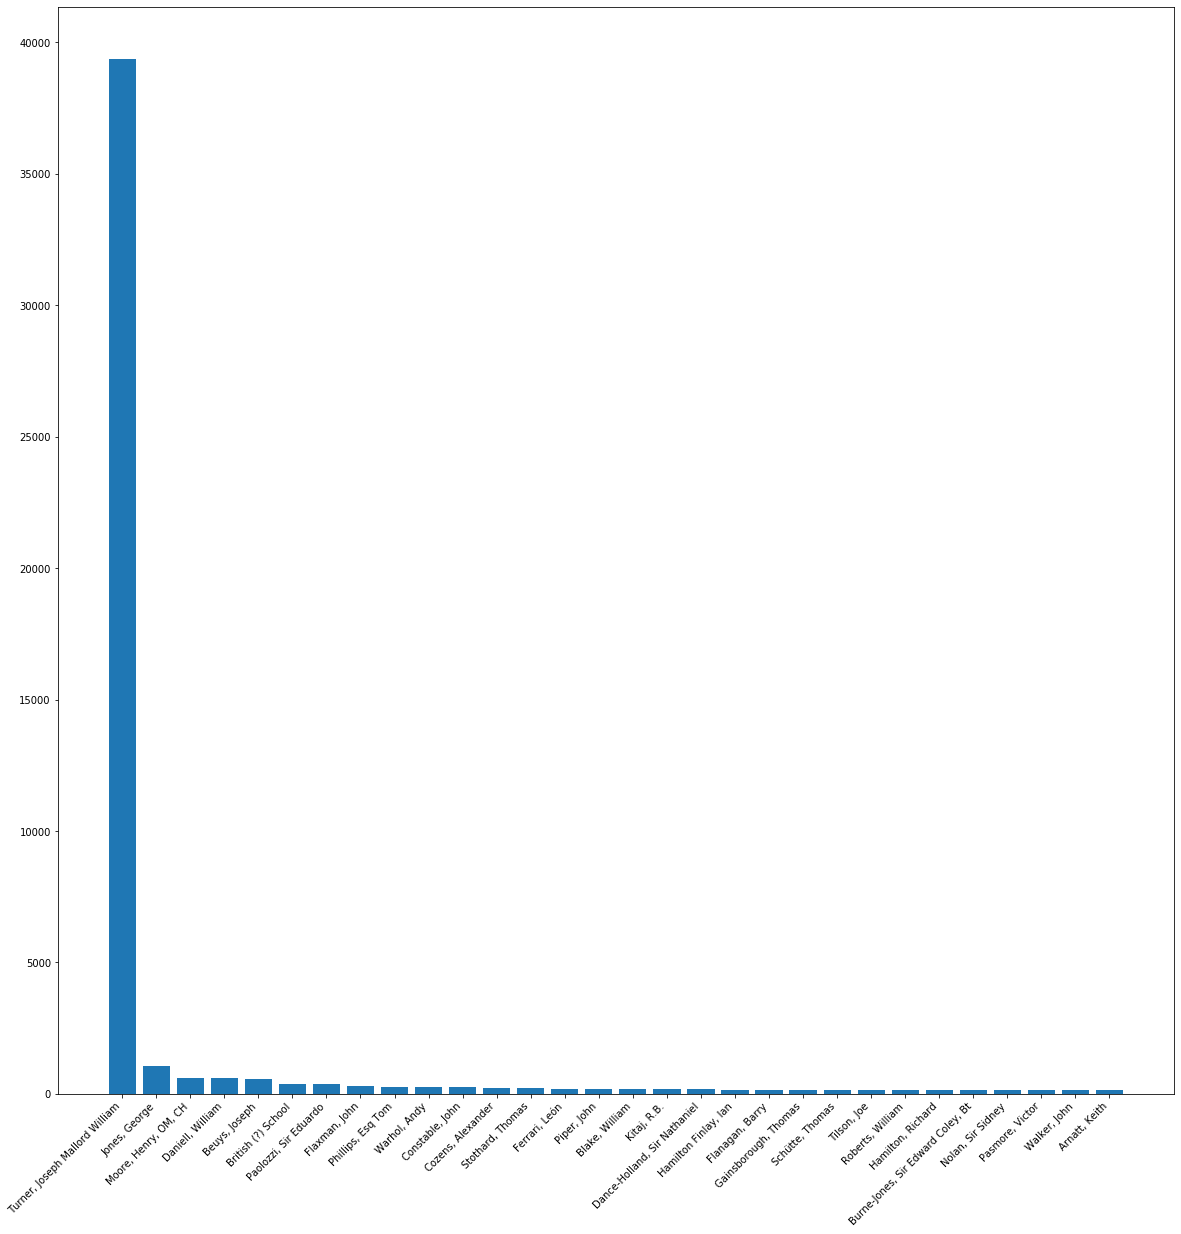

In [20]:
fig = plt.figure(figsize = [20,20])
ax = fig.subplots()
ax.bar(x=np.arange(30), height=art_per_artists.iloc[:30,:]['id'].values)
ax.set_xticks(np.arange(30))
_ = ax.set_xticklabels(artists_30, rotation=45,ha='right')

In [21]:
art_per_artists

id  accession_number  artistRole  artistId  \
artist                                                                          
Turner, Joseph Mallord William  39389             39389       39389     39389   
Jones, George                    1046              1046        1046      1046   
Moore, Henry, OM, CH              623               623         623       623   
Daniell, William                  612               612         612       612   
Beuys, Joseph                     578               578         578       578   
...                               ...               ...         ...       ...   
Janas, Piotr                        1                 1           1         1   
Jamieson, Alexander                 1                 1           1         1   
James, A. Gosset                    1                 1           1         1   
Jagger, Charles Sargeant            1                 1           1         1   
Koch, Eleanor                       1                 1           1         1   

                                title  dateText  medium  creditLine   year  \
artist                                                                       
Turner, Joseph Mallord William  39389     39389   39389       39389  39389   
Jones, George                    1046      1046    1046        1046   1046   
Moore, Henry, OM, CH              623       623     623         623    623   
Daniell, William                  612       612     612         612    612   
Beuys, Joseph                     578       578     578         578    578   
...                               ...       ...     ...         ...    ...   
Janas, Piotr                        1         1       1           1      1   
Jamieson, Alexander                 1         1       1           1      1   
James, A. Gosset                    1         1       1           1      1   
Jagger, Charles Sargeant            1         1       1           1      1   
Koch, Eleanor                       1         1       1           1      1   

                                acquisitionYear  dimensions  width  height  \
artist                                                                       
Turner, Joseph Mallord William            39389       39389  39389   39389   
Jones, George                              1046        1046   1046    1046   
Moore, Henry, OM, CH                        623         623    623     623   
Daniell, William                            612         612    612     612   
Beuys, Joseph                               578         578    578     578   
...                                         ...         ...    ...     ...   
Janas, Piotr                                  1           1      1       1   
Jamieson, Alexander                           1           1      1       1   
James, A. Gosset                              1           1      1       1   
Jagger, Charles Sargeant                      1           1      1       1   
Koch, Eleanor                                 1           1      1       1   

                                depth  units  inscription  thumbnailCopyright  \
artist                                                                          
Turner, Joseph Mallord William  39389  39389        39389               39389   
Jones, George                    1046   1046         1046                1046   
Moore, Henry, OM, CH              623    623          623                 623   
Daniell, William                  612    612          612                 612   
Beuys, Joseph                     578    578          578                 578   
...                               ...    ...          ...                 ...   
Janas, Piotr                        1      1            1                   1   
Jamieson, Alexander                 1      1            1                   1   
James, A. Gosset                    1      1            1                   1   
Jagger, Charles Sargeant            1      1            1   

### COMPUTING COLOUR DISTRIBUTION

To form the dataset, all the remaining images first need to be downloaded. To do so, the link to the thumbnail image is used in conjunction to the urllib library to retrieve and save the images.  Some urls provided were not functioning and thus some images could not be downloaded. These images were therefore removed from the dataset, further reducing the number of rows of the table by 164.

The next few cells have been commented out as they require long run times (about 20 hours) and download 350MB of images. The code is still functional and can be uncommented if desired.

In [22]:
# errors = {}
# x = os.listdir("./img")
# for i in artworks_with_images.index:
#     print(i)
#     if (str(i)+".jpg" not in x):
#         try: 
#             urllib.request.urlretrieve(artworks_with_images['thumbnailUrl'].loc[i], "img/"+str(i)+".jpg")
#         except:
#             errors[i] = "couldn't retrieve the image"

In [23]:
# len(errors.keys())

In [24]:
# artworks_with_images.shape[0]+len(errors.keys())

In [25]:
# artworks_with_images = artworks_with_images.drop(errors.keys(), axis=0)

Once the images are downloaded and the dataset is cleaned, the colour composition of each image needs to be computed. Colour composition analysis can be undertaken using clustering methods that would isolate the specific colours used for each painting and the surface that they cover. However, such a method would not allow for normalisation of the dataset. Indeed, as the data needs to fit a table structure for the analysis, the colours identified for wall paintings need to be comparable. Therefore, a set of colours has been defined and each pixel is assigned one colour from said set. In order to classify each pixel, the geometric distances on the RGB space between the pixel and the colours selected are computed (in function calculate_distance), and the pixel is assigned the colour to which it is the closest (in function find_closest_colour). This process is followed for each pixel in the image (in function extract_colour_distribution) and each image in the dataset.


In [26]:
COLOURS_CHOSEN = {'black' : (0,0,0),
                 'gray' : (128, 128, 128) ,
                 'white': (256,256,256) ,
                 'blue' : (52, 152, 219) ,
                 'light blue' : (135, 206, 250) ,
                 'red' : (231, 76, 60) ,
                 'pink' : (255, 182, 193) ,
                 'yellow' : (241, 196, 15) ,
                 'green' : (39, 174, 96) ,
                 'pale green' : (152, 251, 152) ,
                 'orange' : (243, 156, 18) ,
                 'purple' : (142, 68, 173) ,
                 'brown' : (128, 51, 0) }


In [27]:


def calculate_distance(tuple1, tuple2):
    distance = 0
    for i in range(len(tuple1)):
        distance += (tuple1[i] - tuple2[i])**2
    return distance


#this is the main method to sort the pixel's colour into the closest colour
def find_closest_colour(tuple_colour_input, dict_colours = COLOURS_CHOSEN):
    distance_min = -1
    closest_colour = None
    for key in dict_colours:
    #this creates a loop to check to closest colour to the pixel's colour,
    #checking the chosen colours one by one
        temp_dist = calculate_distance(tuple_colour_input, dict_colours[key])
        if distance_min == -1 or temp_dist < distance_min:
            closest_colour = key
            distance_min = temp_dist
    return closest_colour

def extract_colour_distribution(image, dict_colours = COLOURS_CHOSEN):
    image = image.convert("RGB")
    pixels = image.getdata()
    output_dict = {}
    for key in dict_colours:
        output_dict[key] = 0
    for pixel in pixels:
        output_dict[find_closest_colour(pixel)] += 1
    return output_dict

In [28]:
# dicty = {}
# dicty['id'] = []
# for col in COLOURS_CHOSEN.keys():
#     dicty[col] = []
# dicty

In [29]:
# for img in artworks_with_images.index:
#     if img not in dicty['id']:
#         tmp = Image.open(f'img/{img}.jpg')
#         dict_colours = extract_colour_distribution(tmp)
#         dicty['id'].append(img)
#         for col in dict_colours.keys():
#             dicty[col].append(dict_colours[col])
#         if int(i/100) == i/100:
#             print(f'{i} images done out of {artworks_with_images.shape[0]}')
# colour_df = pd.DataFrame.from_dict(dicty)

In [30]:
# colour_df.to_csv('colours_final.csv')

In [31]:
colour_df = pd.read_csv('colours_final.csv')
colour_df

Unnamed: 0      id  black   gray  white  blue  light blue  red   pink  \
0               0    1035  22352  27530     11     0           0    0   5376   
1               1    1036   5524   5779      0     0           0    0  33640   
2               2    1037      0   1935      0     0           0    0  44657   
3               3    1038   2066    785  20218     0           0    0  29561   
4               4    1039      1  14244   8905     0           0    0  28453   
...           ...     ...    ...    ...    ...   ...         ...  ...    ...   
58169       46261  127131   4099   3535   6460     0           0    0  17526   
58170       46262  121283  32958   5834    164     0           0    0    530   
58171       46263  129068   1682  16966  28596     0          89    0   2314   
58172       46264  122958   4557  17962  30742     0           0    0   7583   
58173       46265  122959   5350  16600  32347     0           0    0   8124   

       yellow  green  pale green  orange  purple  brown  total  
0           0      0           0       0       0   7195  62464  
1           0      0         134       0       0    235  45312  
2           0      0           0       0       0      0  46592  
3           0      0          10       0       0   1120  53760  
4           0      0           0       0       0    365  51968  
...       ...    ...         ...     ...     ...    ...    ...  
58169       0      0           5       0       0   3447  35072  
58170       0      0           9       0       0   4025  43520  
58171       0     10         127       0       0   2952  52736  
58172       0      0          11       0       0   4425  65280  
58173       0      0           7       0       0   2340  64768  

[58174 rows x 16 columns]

In [32]:
colour_df = colour_df.drop_duplicates(subset='id')

In [33]:
colour_df = colour_df[['id', 'black', 'gray', 'white', 'blue', 'light blue', 'red', 'pink', 'yellow', 'green', 'pale green', 'orange', 'purple', 'brown']].set_index('id')
colour_df['total'] = colour_df[['black', 'gray', 'white', 'blue', 'light blue', 'red', 'pink', 'yellow', 'green', 'pale green', 'orange', 'purple', 'brown']].sum(axis=1)
colour_df

black   gray  white  blue  light blue  red   pink  yellow  green  \
id                                                                         
1035    22352  27530     11     0           0    0   5376       0      0   
1036     5524   5779      0     0           0    0  33640       0      0   
1037        0   1935      0     0           0    0  44657       0      0   
1038     2066    785  20218     0           0    0  29561       0      0   
1039        1  14244   8905     0           0    0  28453       0      0   
...       ...    ...    ...   ...         ...  ...    ...     ...    ...   
127131   4099   3535   6460     0           0    0  17526       0      0   
121283  32958   5834    164     0           0    0    530       0      0   
129068   1682  16966  28596     0          89    0   2314       0     10   
122958   4557  17962  30742     0           0    0   7583       0      0   
122959   5350  16600  32347     0           0    0   8124       0      0   

        pale green  orange  purple  brown  total  
id                                                
1035             0       0       0   7195  62464  
1036           134       0       0    235  45312  
1037             0       0       0      0  46592  
1038            10       0       0   1120  53760  
1039             0       0       0    365  51968  
...            ...     ...     ...    ...    ...  
127131           5       0       0   3447  35072  
121283           9       0       0   4025  43520  
129068         127       0       0   2952  52736  
122958          11       0       0   4425  65280  
122959           7       0       0   2340  64768  

[46572 rows x 14 columns]

In [34]:
artworks_colours = colour_df.join(artworks_with_images)

In [35]:
artworks_colours

black   gray  white  blue  light blue  red   pink  yellow  green  \
id                                                                         
1035    22352  27530     11     0           0    0   5376       0      0   
1036     5524   5779      0     0           0    0  33640       0      0   
1037        0   1935      0     0           0    0  44657       0      0   
1038     2066    785  20218     0           0    0  29561       0      0   
1039        1  14244   8905     0           0    0  28453       0      0   
...       ...    ...    ...   ...         ...  ...    ...     ...    ...   
127131   4099   3535   6460     0           0    0  17526       0      0   
121283  32958   5834    164     0           0    0    530       0      0   
129068   1682  16966  28596     0          89    0   2314       0     10   
122958   4557  17962  30742     0           0    0   7583       0      0   
122959   5350  16600  32347     0           0    0   8124       0      0   

        pale green  ...                name  gender      dates  yearOfBirth  \
id                  ...                                                       
1035             0  ...       Blake, Robert    Male  1762–1787         1762   
1036           134  ...       Blake, Robert    Male  1762–1787         1762   
1037             0  ...       Blake, Robert    Male  1762–1787         1762   
1038            10  ...       Blake, Robert    Male  1762–1787         1762   
1039             0  ...      Blake, William    Male  1757–1827         1757   
...            ...  ...                 ...     ...        ...          ...   
127131           5  ...        Lord, Andrew    Male  born 1950         1950   
121283           9  ...         Rhodes, Lis  Female  born 1942         1942   
129068         127  ...        Lord, Andrew    Male  born 1950         1950   
122958          11  ...  P-Orridge, Genesis    Male  born 1950         1950   
122959           7  ...  P-Orridge, Genesis    Male  born 1950         1950   

       yearOfDeath                placeOfBirth            placeOfDeath  \
id                                                                       
1035          1787      London, United Kingdom  London, United Kingdom   
1036          1787      London, United Kingdom  London, United Kingdom   
1037          1787      London, United Kingdom  London, United Kingdom   
1038          1787      London, United Kingdom  London, United Kingdom   
1039          1827      London, United Kingdom  London, United Kingdom   
...            ...                         ...                     ...   
127131                Rochdale, United Kingdom                           
121283                  London, United Kingdom                           
129068                Rochdale, United Kingdom                           
122958              Manchester, United Kingdom                           
122959              Manchester, United Kingdom                           

                                               url_artist cityOfBirth  \
id                                                                      
1035    http://www.tate.org.uk/art/artists/robert-blak...      London   
1036    http://www.tate.org.uk/art/artists/robert-blak...      London   
1037    http://www.tate.org.uk/art/artists/robert-blak...      London   
1038    http://www.tate.org.uk/art/artists/robert-blak...      London   
1039    http://www.tate.org.uk/art/artists/william-bla...      London   
...                                                   ...         ...   
127131  http://www.tate.org.uk/art/artists/andrew-lord...    Rochdale   
121283  http://www.tate.org.uk/art/artists/lis-rhodes-...      London   
129068  http://www.tate.org.uk/art/artists/andrew-lord...    Rochdale   
122958  http://www.tate.org.uk/art/artists/genesis-p-o...  Manchester   
122959  http://www.tate.org.uk/art/artists/genesis-p-o...  Manchester   

        countryOfBirth  
id                      
1035    United Kingdom  
103

### NORMALISING COUNTRY NAMES

The resulting table containing the colour distribution of all images is joined to the artworks table using the image ID. The resulting table is the final table to be used for the analysis. The final step in cleaning the dataset is to normalise the country names to be plotted. First, a shapefile containing country boundaries and country names in various languages is imported.  

In [36]:
country_names = gpd.read_file('test_countries/ne_50m_admin_0_countries.shp', encoding='utf-8', na_filter= False)

In [37]:
all_countries = artworks_colours['countryOfBirth'].drop_duplicates().dropna().values

In [38]:
artworks_colours.loc[artworks_colours['countryOfBirth'] == 'Rossiya']

black   gray  white  blue  light blue    red   pink  yellow  green  \
id                                                                          
7073       0   1527   5702     0           0  15533  38625       0      0   
7074       0    607  26461     0           0   3479  19573       0      0   
7075       0    828   3072     0           0   5790  33742       0      0   
7076       0    838   3418     0           0   6040  32943       0      0   
7077       0   1618   2630     0           0  12551  25562       0      0   
...      ...    ...    ...   ...         ...    ...    ...     ...    ...   
25837      0    103      0     0           0      0  40087       0      0   
25838      0     26      1     0           0      0  40164       0      0   
25935      0     78      0     0           0      0  41648       0      0   
25936      0    136      0     0           0      0  43384       0      0   
25940    279  30586      0     0           0      0  12196       0      0   

       pale green  ...                  name  gender      dates  yearOfBirth  \
id                 ...                                                         
7073            0  ...  Jacovleff, Alexandre    Male  1887–1938         1887   
7074            0  ...  Jacovleff, Alexandre    Male  1887–1938         1887   
7075            0  ...  Jacovleff, Alexandre    Male  1887–1938         1887   
7076            0  ...  Jacovleff, Alexandre    Male  1887–1938         1887   
7077            3  ...  Jacovleff, Alexandre    Male  1887–1938         1887   
...           ...  ...                   ...     ...        ...          ...   
25837           2  ...     Cozens, Alexander    Male  1717–1786         1717   
25838           1  ...     Cozens, Alexander    Male  1717–1786         1717   
25935           2  ...     Cozens, Alexander    Male  1717–1786         1717   
25936           0  ...     Cozens, Alexander    Male  1717–1786         1717   
25940          62  ...     Cozens, Alexander    Male  1717–1786         1717   

      yearOfDeath              placeOfBirth            placeOfDeath  \
id                                                                    
7073         1938  Sankt-Peterburg, Rossiya           Paris, France   
7074         1938  Sankt-Peterburg, Rossiya           Paris, France   
7075         1938  Sankt-Peterburg, Rossiya           Paris, France   
7076         1938  Sankt-Peterburg, Rossiya           Paris, France   
7077         1938  Sankt-Peterburg, Rossiya           Paris, France   
...           ...                       ...                     ...   
25837        1786                   Rossiya  London, United Kingdom   
25838        1786                   Rossiya  London, United Kingdom   
25935        1786                   Rossiya  London, United Kingdom   
25936        1786                   Rossiya  London, United Kingdom   
25940        1786                   Rossiya  London, United Kingdom   

                                              url_artist      cityOfBirth  \
id                                                                          
7073   http://www.tate.org.uk/art/artists/alexandre-j...  Sankt-Peterburg   
7074   http://www.tate.org.uk/art/artists/alexandre-j...  Sankt-Peterburg   
7075   http://www.tate.org.uk/art/artists/alexandre-j...  Sankt-Peterburg   
7076   http://www.tate.org.uk/art/artists/alexandre-j...  Sankt-Peterburg   
7077   http://www.tate.org.uk/art/artists/alexandre-j...  Sankt-Peterburg   
...                                                  ...              ...   
25837  http://www.tate.org.uk/art/artists/alexander-c...          Unknown   
25838  http://www.tate.org.uk/art/artists/alexander-c...          Unknown   
25935  http://www.tate.org.uk/art/artists/alexander-c...          Unknown   
25936  http://www.tate.org.uk/art/artists/alexander-c...          Unknown   
25940  http://www.tate.org.uk/art/artists/alexander-c...          Unknown   

      countryOfBirth  
id             

An attempt is made to match each country of the artwork dataset to the geometry in the shapefile. For countries that are not found, the normalisation is done manually. 

In [39]:
mapping = {}
for country in all_countries:
    result = 0
    for col in country_names.columns:
        tmp = country_names.loc[country_names[col] == country].shape[0]
        if tmp != 0:
            result+=1
    if result == 0:
        mapping[country] = ''
        print(f'There was no result for {country}')

C:\Users\margo\Anaconda3\lib\site-packages\pandas\core\ops\__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


There was no result for Bharat
There was no result for Viet Nam
There was no result for Rossiya
There was no result for Ellás
There was no result for Latvija
There was no result for Éire
There was no result for Edinburgh
There was no result for Rochdale
There was no result for Charlotte Amalie
There was no result for Misr
There was no result for România
There was no result for Hrvatska
There was no result for Jugoslavija
There was no result for Yisra'el
There was no result for Nihon
There was no result for Niederschlesien
There was no result for Îran
There was no result for Al-Lubnan
There was no result for Lietuva
There was no result for Bristol
There was no result for Zhonghua
There was no result for London
There was no result for Epsom
There was no result for Ísland
There was no result for Mehoz, Yisra'el
There was no result for Douglas
There was no result for Hertfordshire
There was no result for Stockholm
There was no result for Shqipëria
There was no result for Slovenská Republik

In [40]:
mapping = {'Bharat': 'India',
 'Viet Nam': 'Vietnam',
 'Rossiya': 'Russia',
 'Ellás': 'Greece',
 'Latvija': 'Latvia',
 'Éire': 'Ireland',
 'Edinburgh': 'United Kingdom',
 'Rochdale': 'United Kingdom',
 'Charlotte Amalie': 'United States',
 'Misr': 'Egypt',
 'România': 'Romania',
 'Hrvatska': 'Croatia',
 'Jugoslavija': 'Serbia',
 "Yisra'el": 'Israel',
 'Nihon': 'Japan',
 'Niederschlesien': 'Poland',
 'Îran': 'Iran',
 'Al-Lubnan': 'Lebanon',
 'Lietuva': 'Lithuania',
 'Bristol': 'United Kingdom',
 'Zhonghua': 'China',
 'London': 'United Kingdom',
 'Epsom': 'United Kingdom',
 'Ísland': 'Iceland',
 "Mehoz, Yisra'el": 'Israel',
 'Douglas': 'United Kingdom',
 'Hertfordshire': 'United Kingdom',
 'Stockholm': 'Sweden',
 'Shqipëria': 'Albania',
 'Slovenská Republika': 'Slovakia',
 "Al-Jaza'ir": 'Algeria',
 'Ceská Republika': 'Czechia',
 'Bosna i Hercegovina': 'Bosnia and Herzegovina',
 'Ukrayina': 'Ukraine',
 'Lao': 'Laos',
 "Taehan Min'guk": 'South Korea',
 'As-Sudan': 'Sudan',
'Polska': 'Poland',
'Sverige': 'Sweden'}

It also appears that some city names were mistakenly put in the country column. In that case, the city name is written in the city column before overwriting the correct country name. 

In [41]:
artworks_colours['cityOfBirth'].loc[artworks_colours['countryOfBirth'] == 'Bristol'] = 'Bristol'
artworks_colours['cityOfBirth'].loc[artworks_colours['countryOfBirth'] == 'Edinburgh'] = 'Edinburgh'
artworks_colours['cityOfBirth'].loc[artworks_colours['countryOfBirth'] == 'Rochdale'] = 'Rochdale'
artworks_colours['cityOfBirth'].loc[artworks_colours['countryOfBirth'] == 'Charlotte Amalie'] = 'Charlotte Amalie'
artworks_colours['cityOfBirth'].loc[artworks_colours['countryOfBirth'] == 'London'] = 'London'
artworks_colours['cityOfBirth'].loc[artworks_colours['countryOfBirth'] == 'Epsom'] = 'Epsom'
artworks_colours['cityOfBirth'].loc[artworks_colours['countryOfBirth'] == 'Douglas'] = 'Douglas'
artworks_colours['cityOfBirth'].loc[artworks_colours['countryOfBirth'] == 'Hertfordshire'] = 'Hertfordshire'
artworks_colours['cityOfBirth'].loc[artworks_colours['countryOfBirth'] == 'Stockholm'] = 'Stockholm'

C:\Users\margo\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [42]:
artworks_colours['countryOfBirth'].loc[artworks_colours['countryOfBirth'].isin(mapping.keys())] = artworks_colours['countryOfBirth'].loc[artworks_colours['countryOfBirth'].isin(mapping.keys())].map(mapping)

The columns containing the matched country name and the geometry of each country are then selected and joined with the artwork table.

In [43]:
all_countries = artworks_colours['countryOfBirth'].drop_duplicates().dropna().values
final_countries = {}
country_names["final_country"] = ""
for country in all_countries:
    tmp = country_names.loc[country_names['ADMIN'] == country].shape[0]
    if tmp != 1:
        print(f'nb result for {country}: {tmp}')
        print('trying another way')
        for row in range(country_names.shape[0]):
            vals = country_names.loc[row].values
            if country in vals:
                final_countries[row] = country
                break
    else:
        final_countries[country_names.loc[country_names['ADMIN'] == country].index[0]] = country
        print(f'nb of results for {country}: {tmp}. The row was added into the dictionary')
country_names

nb of results for United Kingdom: 1. The row was added into the dictionary
nb of results for India: 1. The row was added into the dictionary
nb of results for France: 1. The row was added into the dictionary
nb result for Italia: 0
trying another way
nb of results for Vietnam: 1. The row was added into the dictionary
nb of results for Russia: 1. The row was added into the dictionary
nb result for United States: 0
trying another way
nb result for Bahamas: 0
trying another way
nb result for Deutschland: 0
trying another way
nb of results for Australia: 1. The row was added into the dictionary
nb of results for Greece: 1. The row was added into the dictionary
nb result for België: 0
trying another way
nb of results for Latvia: 1. The row was added into the dictionary
nb of results for Canada: 1. The row was added into the dictionary
nb of results for Ireland: 1. The row was added into the dictionary
nb result for Schweiz: 0
trying another way
nb result for España: 0
trying another way
nb 

featurecla  scalerank  LABELRANK   SOVEREIGNT SOV_A3  ADM0_DIF  \
0    Admin-0 country          1          3     Zimbabwe    ZWE         0   
1    Admin-0 country          1          3       Zambia    ZMB         0   
2    Admin-0 country          1          3        Yemen    YEM         0   
3    Admin-0 country          3          2      Vietnam    VNM         0   
4    Admin-0 country          5          3    Venezuela    VEN         0   
..               ...        ...        ...          ...    ...       ...   
236  Admin-0 country          1          6      Albania    ALB         0   
237  Admin-0 country          1          3  Afghanistan    AFG         0   
238  Admin-0 country          1          5      Kashmir    KAS         0   
239  Admin-0 country          3          4   Antarctica    ATA         0   
240  Admin-0 country          3          6  Netherlands    NL1         1   

     LEVEL               TYPE            ADMIN ADM0_A3  ...          NAME_NL  \
0        2  Sovereign country         Zimbabwe     ZWE  ...         Zimbabwe   
1        2  Sovereign country           Zambia     ZMB  ...           Zambia   
2        2  Sovereign country            Yemen     YEM  ...            Jemen   
3        2  Sovereign country          Vietnam     VNM  ...          Vietnam   
4        2  Sovereign country        Venezuela     VEN  ...        Venezuela   
..     ...                ...              ...     ...  ...              ...   
236      2  Sovereign country          Albania     ALB  ...          Albanië   
237      2  Sovereign country      Afghanistan     AFG  ...      Afghanistan   
238      2      Indeterminate  Siachen Glacier     KAS  ...  Siachengletsjer   
239      2      Indeterminate       Antarctica     ATA  ...       Antarctica   
240      2            Country     Sint Maarten     SXM  ...     Sint Maarten   

              NAME_PL             NAME_PT      NAME_RU            NAME_SV  \
0            Zimbabwe            Zimbábue     Зимбабве           Zimbabwe   
1              Zambia              Zâmbia       Замбия             Zambia   
2               Jemen               Iémen        Йемен              Jemen   
3             Wietnam            Vietname      Вьетнам            Vietnam   
4           Wenezuela           Venezuela    Венесуэла          Venezuela   
..                ...                 ...          ...                ...   
236           Albania             Albânia      Албания           Albanien   
237        Afganistan         Afeganistão   Афганистан        Afghanistan   
238  Lodowiec Siachen  Glaciar de Siachen       Сиачен  Siachen Glaciären   
239        Antarktyda           Antártida   Антарктида          Antarktis   
240      Sint Maarten        São Martinho  Синт-Мартен       Sint Maarten   

            NAME_TR            NAME_VI NAME_ZH  \
0          Zimbabve           Zimbabwe     辛巴威   
1           Zambiya             Zambia     赞比亚   
2             Yemen              Yemen      也门   
3           Vietnam           Việt Nam      越南   
4         Venezuela          Venezuela    委內瑞拉   
..              ...                ...     ...   
236      Arnavutluk            Albania   阿尔巴尼亚   
237      Afganistan        Afghanistan     阿富汗   
238  Siachen Buzulu  Sông băng Siachen   锡亚琴冰川   
239      Antarktika       Châu Nam Cực     南极洲   
240    Sint Maarten       Sint Maarten   荷屬聖馬丁   

                                              geometry final_country  
0    POLYGON ((31.28789062500002 -22.40205078125001...                
1    POLYGON ((30.39609375000001 -15.64306640625, 3...                
2    (POLYGON ((53.08564453125001 16.648388671875, ...                
3    (POLYGON ((104.06396484375 10.3908203125, 104....                
4    (POLYGON ((-60.82119140624999 9.13837890624999...                
..                                                 ...           ...  
236  POLYGON ((19.34238281250001 41.869091796875, 1...                
237  POLYGON ((66.52226562500002 37.348486

In [44]:
final_countries_df = country_names.iloc[:,[7,8, 94]].join(pd.DataFrame.from_dict(final_countries, orient='index').rename(columns={0: 'final_country'}), how='right')

In [45]:
artworks_colours = artworks_colours.join(final_countries_df.set_index('final_country'), on='countryOfBirth')
artworks_colours

black   gray  white  blue  light blue  red   pink  yellow  green  \
id                                                                         
1035    22352  27530     11     0           0    0   5376       0      0   
1036     5524   5779      0     0           0    0  33640       0      0   
1037        0   1935      0     0           0    0  44657       0      0   
1038     2066    785  20218     0           0    0  29561       0      0   
1039        1  14244   8905     0           0    0  28453       0      0   
...       ...    ...    ...   ...         ...  ...    ...     ...    ...   
127131   4099   3535   6460     0           0    0  17526       0      0   
121283  32958   5834    164     0           0    0    530       0      0   
129068   1682  16966  28596     0          89    0   2314       0     10   
122958   4557  17962  30742     0           0    0   7583       0      0   
122959   5350  16600  32347     0           0    0   8124       0      0   

        pale green  ...  yearOfBirth  yearOfDeath                placeOfBirth  \
id                  ...                                                         
1035             0  ...         1762         1787      London, United Kingdom   
1036           134  ...         1762         1787      London, United Kingdom   
1037             0  ...         1762         1787      London, United Kingdom   
1038            10  ...         1762         1787      London, United Kingdom   
1039             0  ...         1757         1827      London, United Kingdom   
...            ...  ...          ...          ...                         ...   
127131           5  ...         1950                 Rochdale, United Kingdom   
121283           9  ...         1942                   London, United Kingdom   
129068         127  ...         1950                 Rochdale, United Kingdom   
122958          11  ...         1950               Manchester, United Kingdom   
122959           7  ...         1950               Manchester, United Kingdom   

                  placeOfDeath  \
id                               
1035    London, United Kingdom   
1036    London, United Kingdom   
1037    London, United Kingdom   
1038    London, United Kingdom   
1039    London, United Kingdom   
...                        ...   
127131                           
121283                           
129068                           
122958                           
122959                           

                                               url_artist cityOfBirth  \
id                                                                      
1035    http://www.tate.org.uk/art/artists/robert-blak...      London   
1036    http://www.tate.org.uk/art/artists/robert-blak...      London   
1037    http://www.tate.org.uk/art/artists/robert-blak...      London   
1038    http://www.tate.org.uk/art/artists/robert-blak...      London   
1039    http://www.tate.org.uk/art/artists/william-bla...      London   
...                                                   ...         ...   
127131  http://www.tate.org.uk/art/artists/andrew-lord...    Rochdale   
121283  http://www.tate.org.uk/art/artists/lis-rhodes-...      London   
129068  http://www.tate.org.uk/art/artists/andrew-lord...    Rochdale   
122958  http://www.tate.org.uk/art/artists/genesis-p-o...  Manchester   
122959  http://www.tate.org.uk/art/artists/genesis-p-o...  Manchester   

        countryOfBirth     TYPE           ADMIN  \
id                                                
1035    United Kingdom  Country  United Kingdom   
1036    United Kingdom  Country  United Kingdom   
1037    United Kingdom  Country  United Kingdom   
1038    United Kingdom  Country  United Kingdom   
1039    United Kingdom  Country  United Kingdom   
...                ...      ...             ...   
127131  United Kingdom  Country  United Kingdom   
121283  United Kingdom  Country  United Kingdom   
129068  United Kingdom  Country  United Kingdom   
122958  Uni

In [46]:
artworks_colours = artworks_colours.dropna(subset=['ADMIN'])

In [47]:
artworks_colours

black   gray  white  blue  light blue  red   pink  yellow  green  \
id                                                                         
1035    22352  27530     11     0           0    0   5376       0      0   
1036     5524   5779      0     0           0    0  33640       0      0   
1037        0   1935      0     0           0    0  44657       0      0   
1038     2066    785  20218     0           0    0  29561       0      0   
1039        1  14244   8905     0           0    0  28453       0      0   
...       ...    ...    ...   ...         ...  ...    ...     ...    ...   
127131   4099   3535   6460     0           0    0  17526       0      0   
121283  32958   5834    164     0           0    0    530       0      0   
129068   1682  16966  28596     0          89    0   2314       0     10   
122958   4557  17962  30742     0           0    0   7583       0      0   
122959   5350  16600  32347     0           0    0   8124       0      0   

        pale green  ...  yearOfBirth  yearOfDeath                placeOfBirth  \
id                  ...                                                         
1035             0  ...         1762         1787      London, United Kingdom   
1036           134  ...         1762         1787      London, United Kingdom   
1037             0  ...         1762         1787      London, United Kingdom   
1038            10  ...         1762         1787      London, United Kingdom   
1039             0  ...         1757         1827      London, United Kingdom   
...            ...  ...          ...          ...                         ...   
127131           5  ...         1950                 Rochdale, United Kingdom   
121283           9  ...         1942                   London, United Kingdom   
129068         127  ...         1950                 Rochdale, United Kingdom   
122958          11  ...         1950               Manchester, United Kingdom   
122959           7  ...         1950               Manchester, United Kingdom   

                  placeOfDeath  \
id                               
1035    London, United Kingdom   
1036    London, United Kingdom   
1037    London, United Kingdom   
1038    London, United Kingdom   
1039    London, United Kingdom   
...                        ...   
127131                           
121283                           
129068                           
122958                           
122959                           

                                               url_artist cityOfBirth  \
id                                                                      
1035    http://www.tate.org.uk/art/artists/robert-blak...      London   
1036    http://www.tate.org.uk/art/artists/robert-blak...      London   
1037    http://www.tate.org.uk/art/artists/robert-blak...      London   
1038    http://www.tate.org.uk/art/artists/robert-blak...      London   
1039    http://www.tate.org.uk/art/artists/william-bla...      London   
...                                                   ...         ...   
127131  http://www.tate.org.uk/art/artists/andrew-lord...    Rochdale   
121283  http://www.tate.org.uk/art/artists/lis-rhodes-...      London   
129068  http://www.tate.org.uk/art/artists/andrew-lord...    Rochdale   
122958  http://www.tate.org.uk/art/artists/genesis-p-o...  Manchester   
122959  http://www.tate.org.uk/art/artists/genesis-p-o...  Manchester   

        countryOfBirth     TYPE           ADMIN  \
id                                                
1035    United Kingdom  Country  United Kingdom   
1036    United Kingdom  Country  United Kingdom   
1037    United Kingdom  Country  United Kingdom   
1038    United Kingdom  Country  United Kingdom   
1039    United Kingdom  Country  United Kingdom   
...                ...      ...             ...   
127131  United Kingdom  Country  United Kingdom   
121283  United Kingdom  Country  United Kingdom   
129068  United Kingdom  Country  United Kingdom   
122958  Uni

Lastly, the colour distribution was turned in percentages to increase comparability of images.

In [48]:
for col in artworks_colours.columns[:13]:
    artworks_colours[f'{col}_pct'] = artworks_colours[col]/artworks_colours['total']

C:\Users\margo\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [49]:
colour_pct = artworks_colours.columns[-13:].tolist()

### DATA EXPLORATION

The data is grouped by country using the average value. This new table is plotted to observe whether the use of certain colours is more prominent in specific countries. 

In [50]:
artworks_grouped_country = artworks_colours.groupby('countryOfBirth').mean()
artworks_grouped_country

black          gray         white        blue  \
countryOfBirth                                                         
Albania         26205.000000   7854.500000    319.500000   30.500000   
Algeria          1843.000000  25013.000000      2.000000    0.000000   
Argentina        3407.414894  10734.202128  12315.446809  191.000000   
Australia        4906.909091  14939.757576  11308.515152   76.621212   
Bahamas          2177.846154   8235.000000  13667.329670  461.296703   
...                      ...           ...           ...         ...   
Venezuela        7203.666667  17572.166667   9969.833333    0.000000   
Vietnam         14430.000000  14131.400000   2102.400000    3.200000   
Zambia           4756.900000  27809.900000   3373.500000  123.300000   
Zimbabwe         4337.000000  10720.600000  19583.200000    0.000000   
Österreich       5174.875000   7549.464286  16196.553571  107.892857   

                 light blue          red          pink       yellow  \
countryOfBirth                                                        
Albania          359.500000  2957.000000    654.000000  3093.000000   
Algeria            0.000000     0.000000   6709.000000     0.000000   
Argentina        270.297872   223.601064  15133.611702    24.617021   
Australia        500.181818   357.757576  11986.136364    42.030303   
Bahamas         1020.175824   970.208791  15015.296703    35.043956   
...                     ...          ...           ...          ...   
Venezuela          0.000000     0.000000  10275.333333     0.000000   
Vietnam           97.600000   589.200000   8068.000000   636.000000   
Zambia          3060.500000     2.800000  11435.300000     0.000000   
Zimbabwe         724.000000   244.300000   6299.900000    96.600000   
Österreich        41.321429  2326.857143  11151.410714   262.446429   

                     green  pale green  ...  blue_pct  light blue_pct  \
countryOfBirth                          ...                             
Albania          10.000000  137.500000  ...  0.000608        0.007142   
Algeria           0.000000   54.000000  ...  0.000000        0.000000   
Argentina        17.085106  151.526596  ...  0.004179        0.005379   
Australia       122.257576  291.757576  ...  0.001609        0.008943   
Bahamas          19.637363  442.010989  ...  0.012086        0.019996   
...                    ...         ...  ...       ...             ...   
Venezuela         0.000000    6.833333  ...  0.000000        0.000000   
Vietnam          43.800000  990.600000  ...  0.000052        0.001717   
Zambia           38.800000   57.700000  ...  0.002161        0.055279   
Zimbabwe          2.100000    2.300000  ...  0.000000        0.013834   
Österreich      773.785714  159.125000  ...  0.002228        0.000836   

                 red_pct  pink_pct  yellow_pct  green_pct  pale green_pct  \
countryOfBirth                                                              
Albania         0.058933  0.013033    0.061643   0.000199        0.002740   
Algeria         0.000000  0.192699    0.000000   0.000000        0.001551   
Argentina       0.004789  0.343012    0.000489   0.000345        0.003192   
Australia       0.007614  0.228924    0.000825   0.002570        0.005546   
Bahamas         0.022975  0.322005    0.000624   0.000497        0.008319   
...                  ...       ...         ...        ...             ...   
Venezuela       0.000000  0.207067    0.000000   0.000000        0.000135   
Vietnam         0.011065  0.153170    0.011895   0.000728        0.018516   
Zambia          0.000063  0.207755    0.000000   0.000687        0.001079   
Zimbabwe        0.004685  0.123354    0.001850   0.000040        0.000044   
Österreich      0.047383  0.239950    0.005158   0.015345        0.003685   

                orange_pct  purple_pct  brown_pct  
countryOfBirth                                     
Albania           0.041155    0.002740   0.131504  
Algeria           0.000000    0.000000   0.034323  
Ar

In [51]:
artworks_grouped_country = artworks_grouped_country.join(final_countries_df.set_index('final_country'))


In [52]:
artworks_grouped_country = gpd.GeoDataFrame(artworks_grouped_country, geometry='geometry')

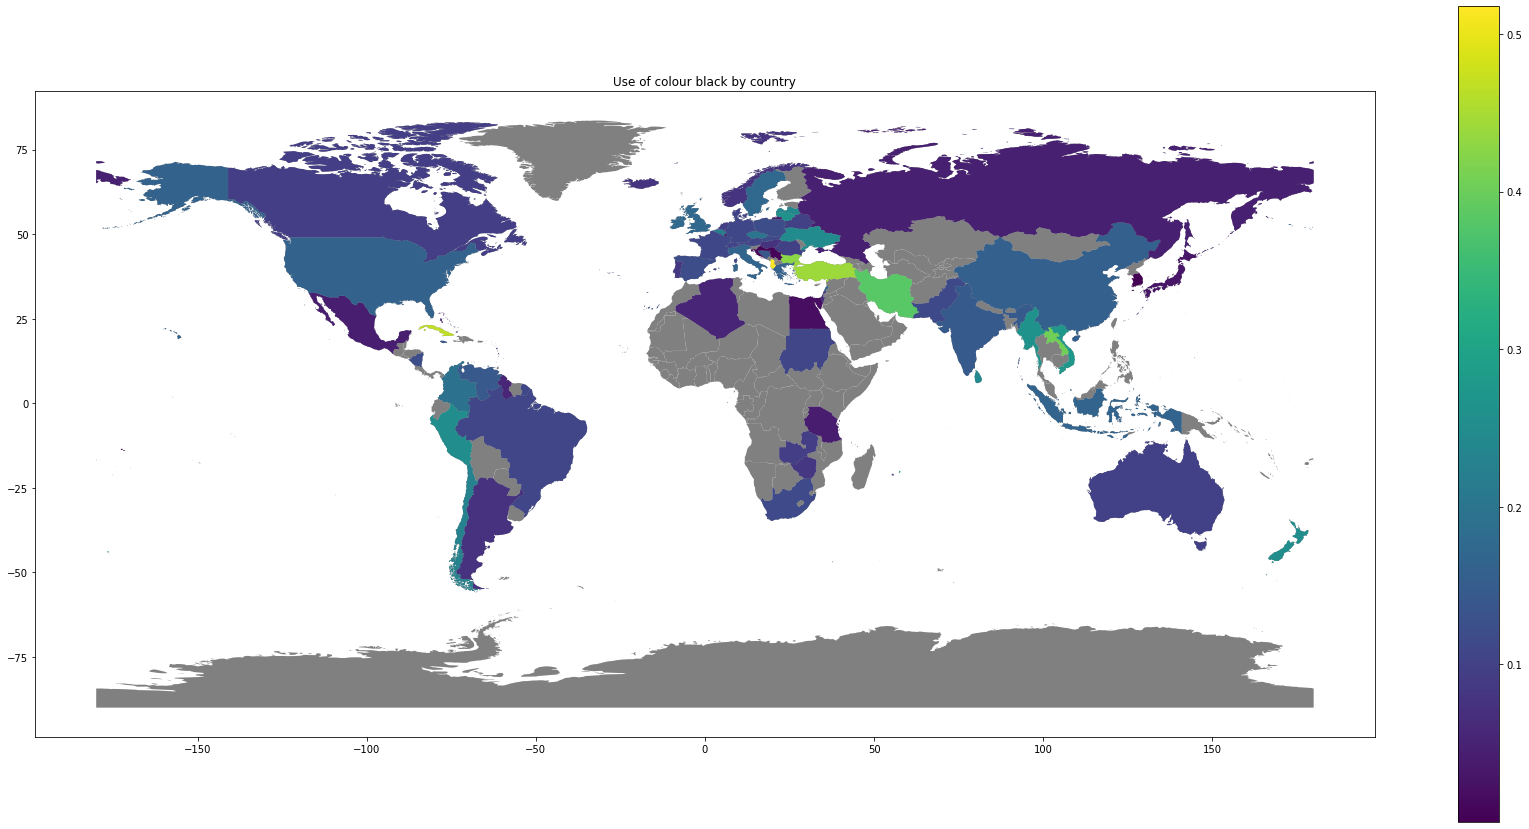

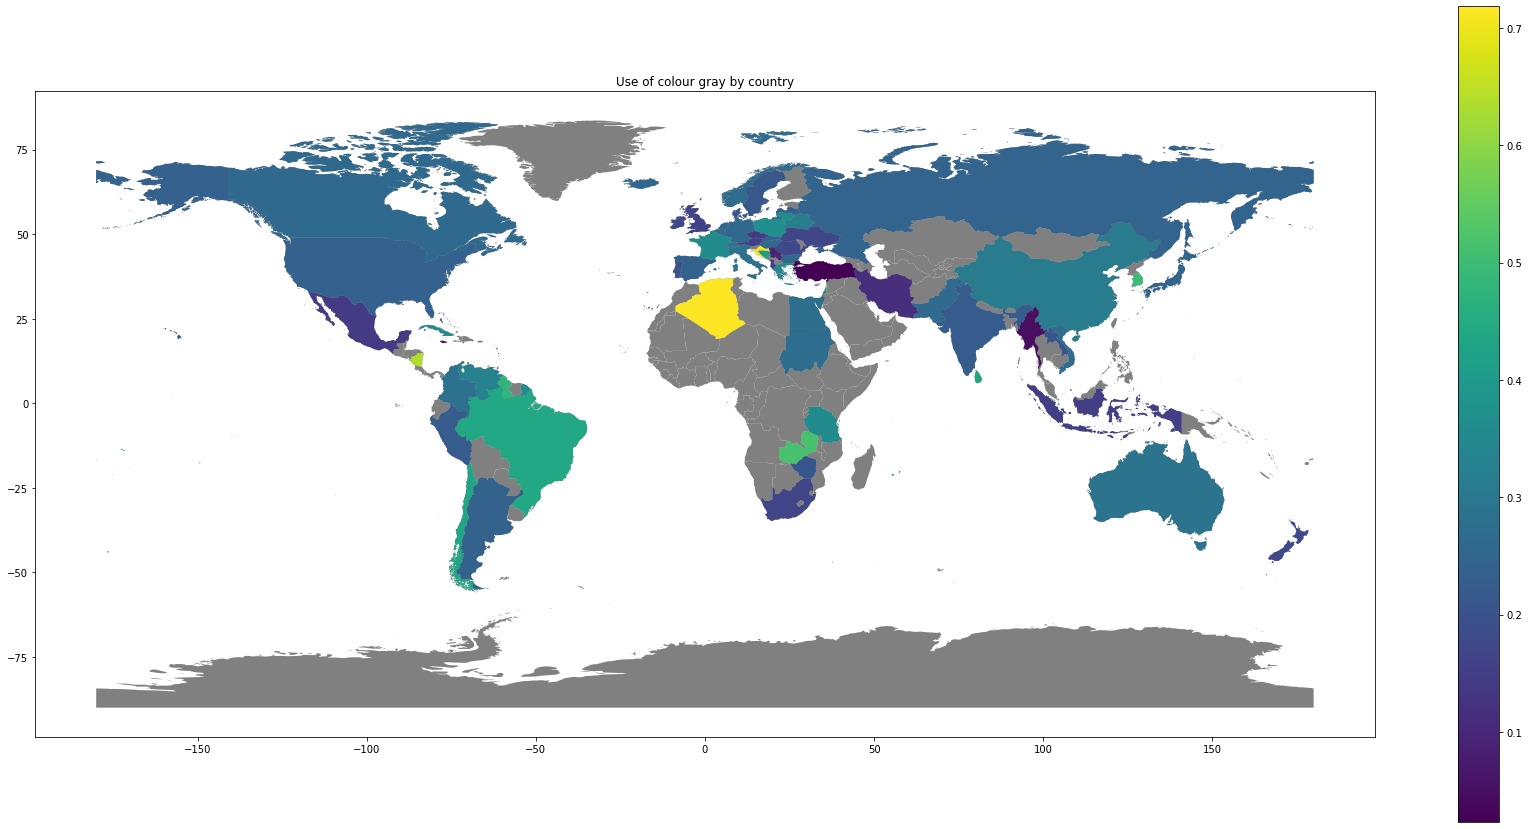

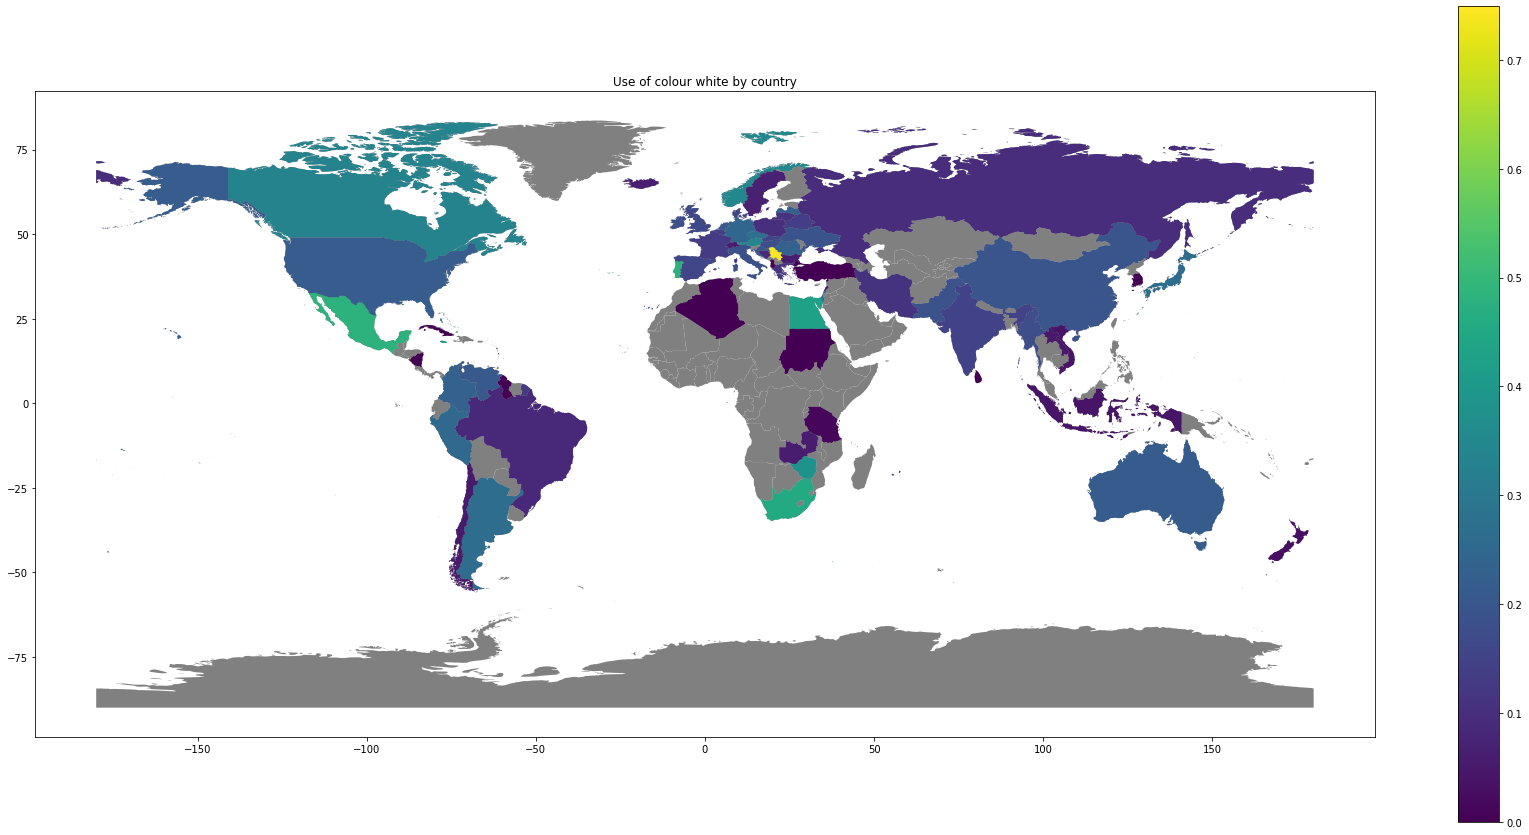

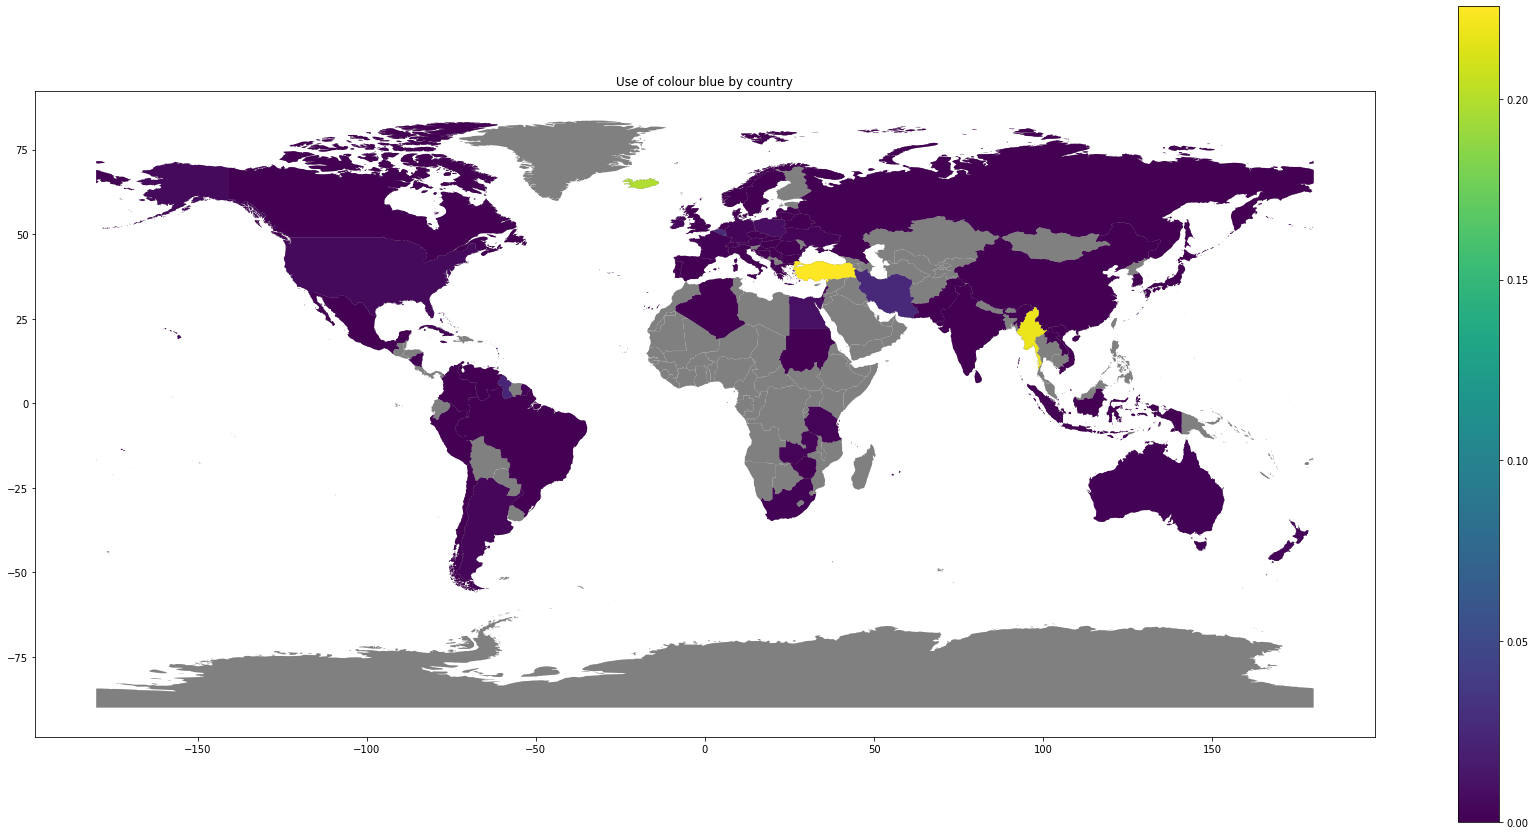

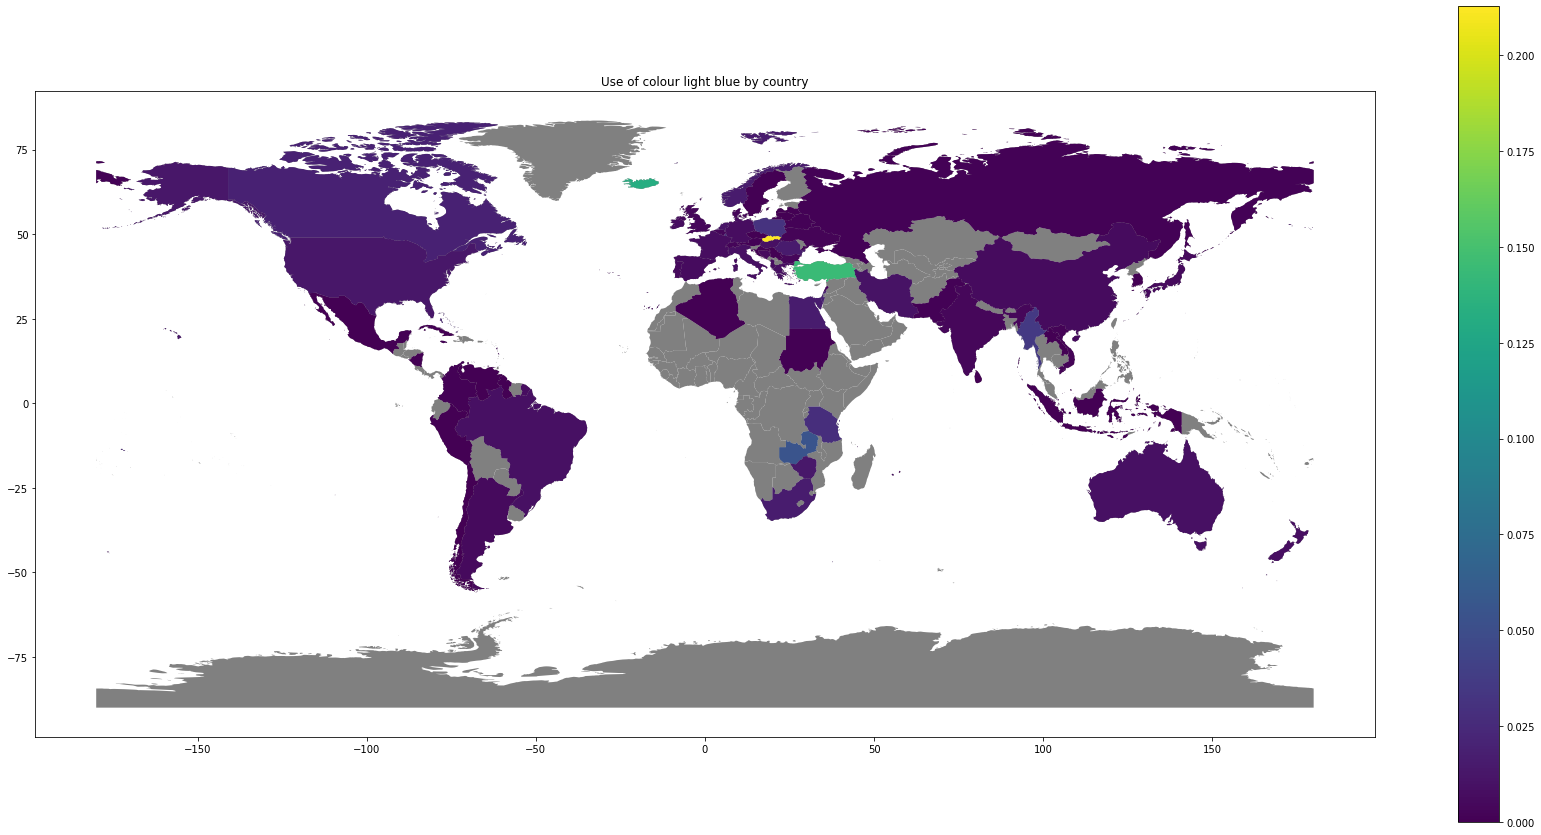

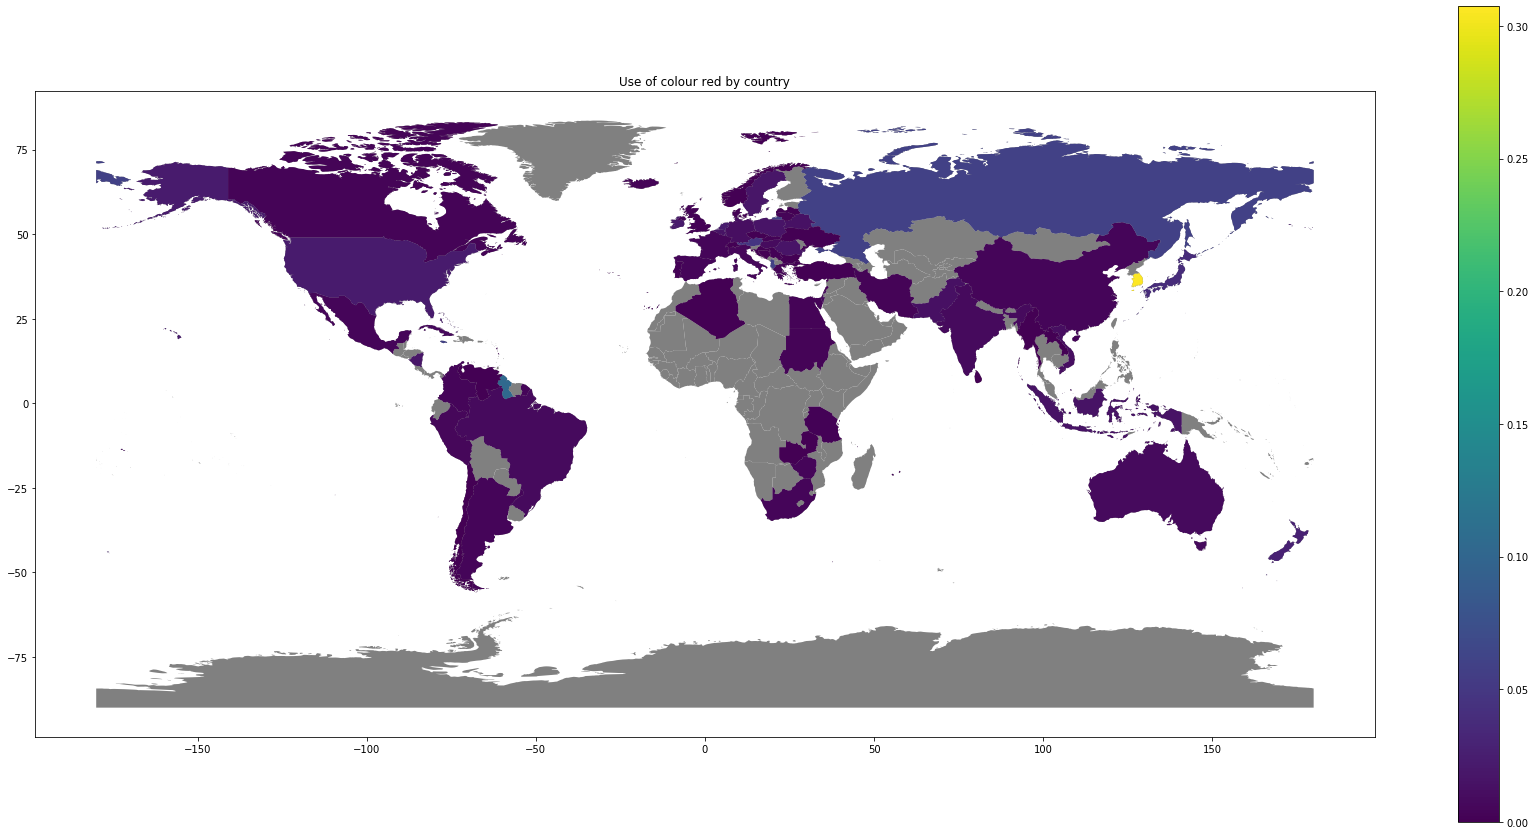

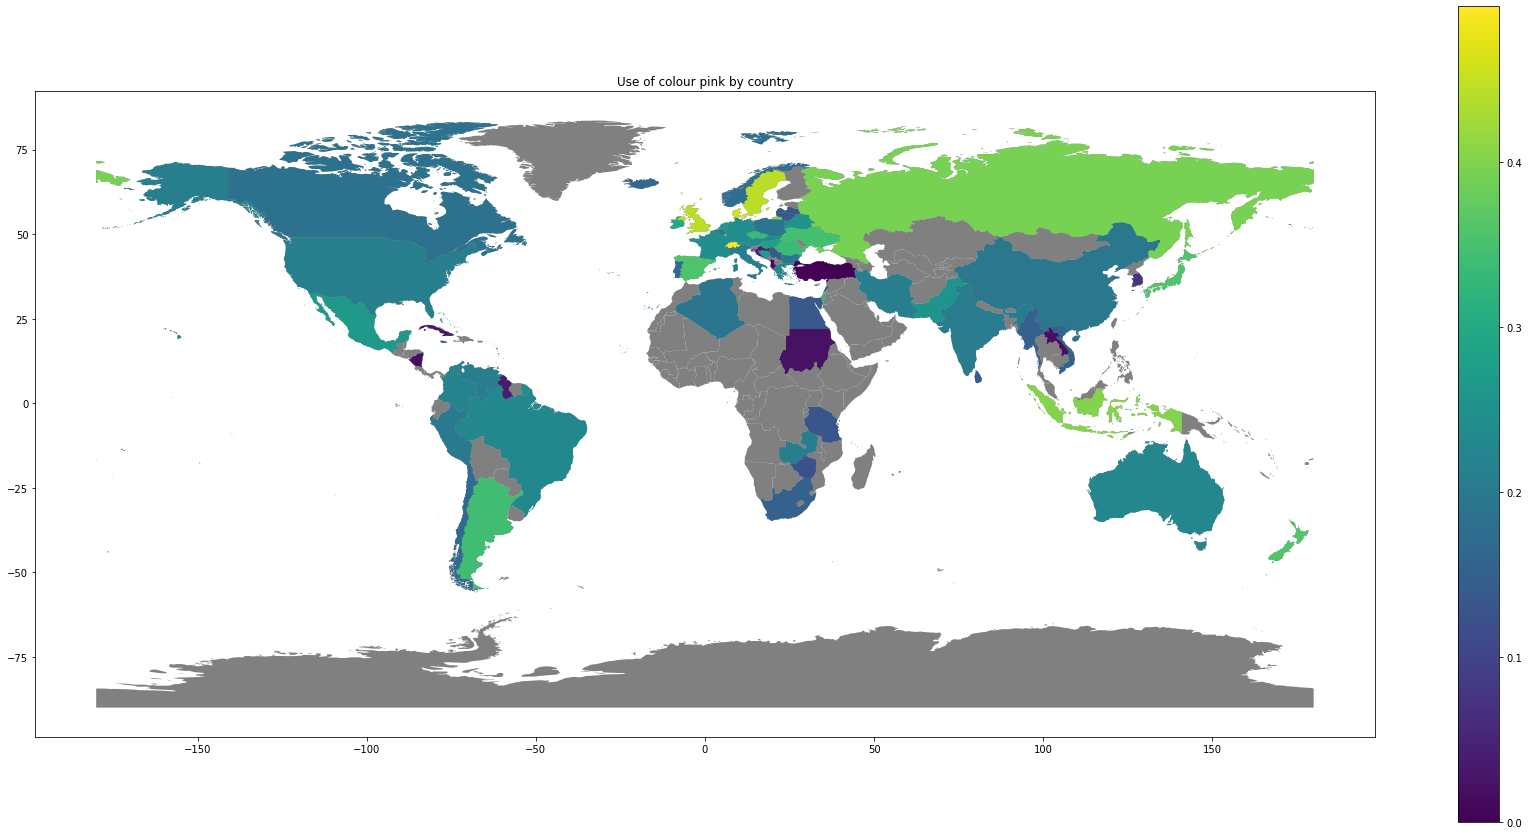

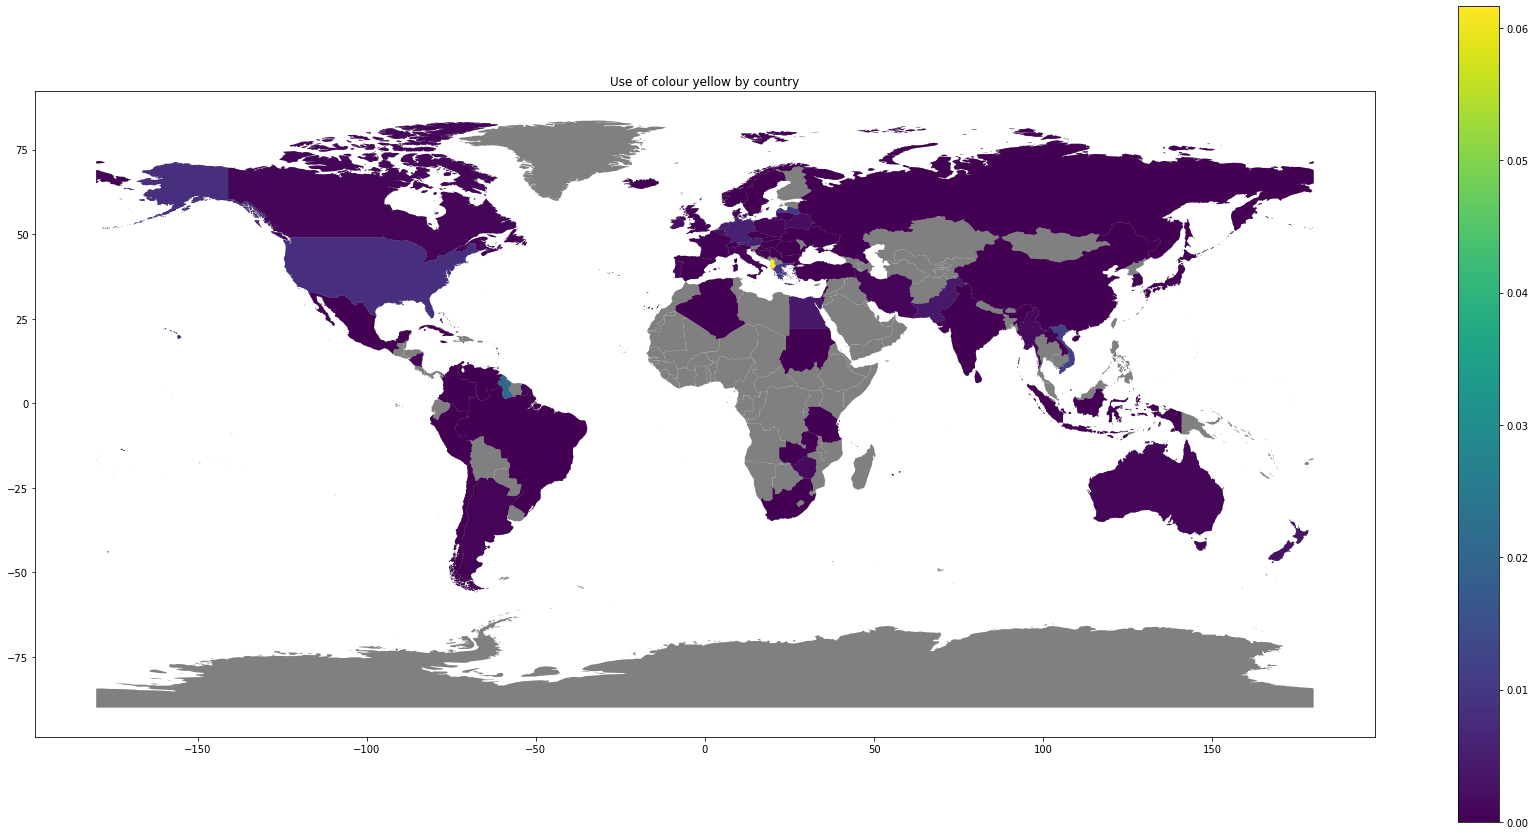

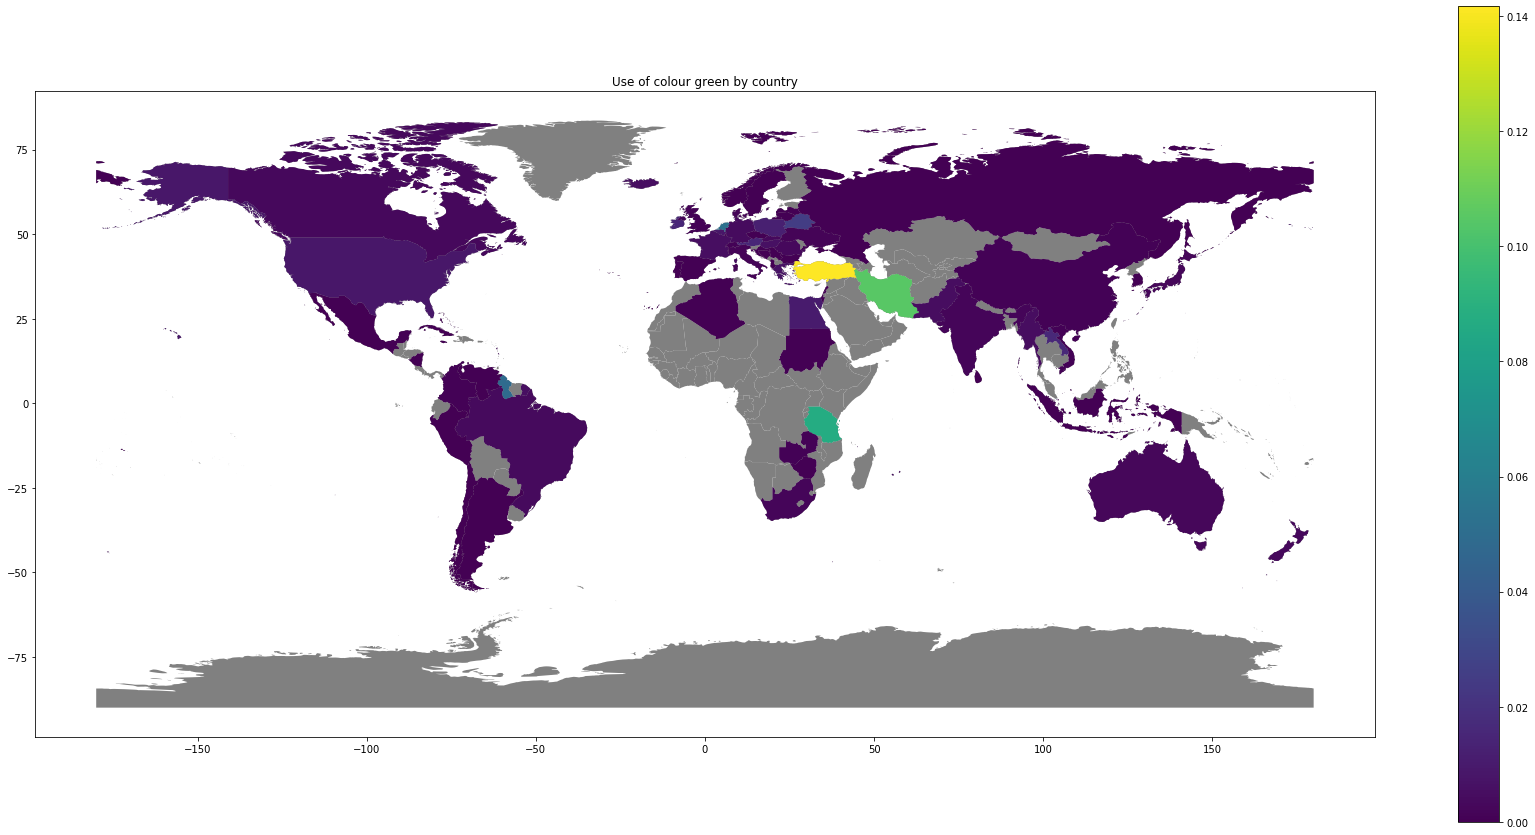

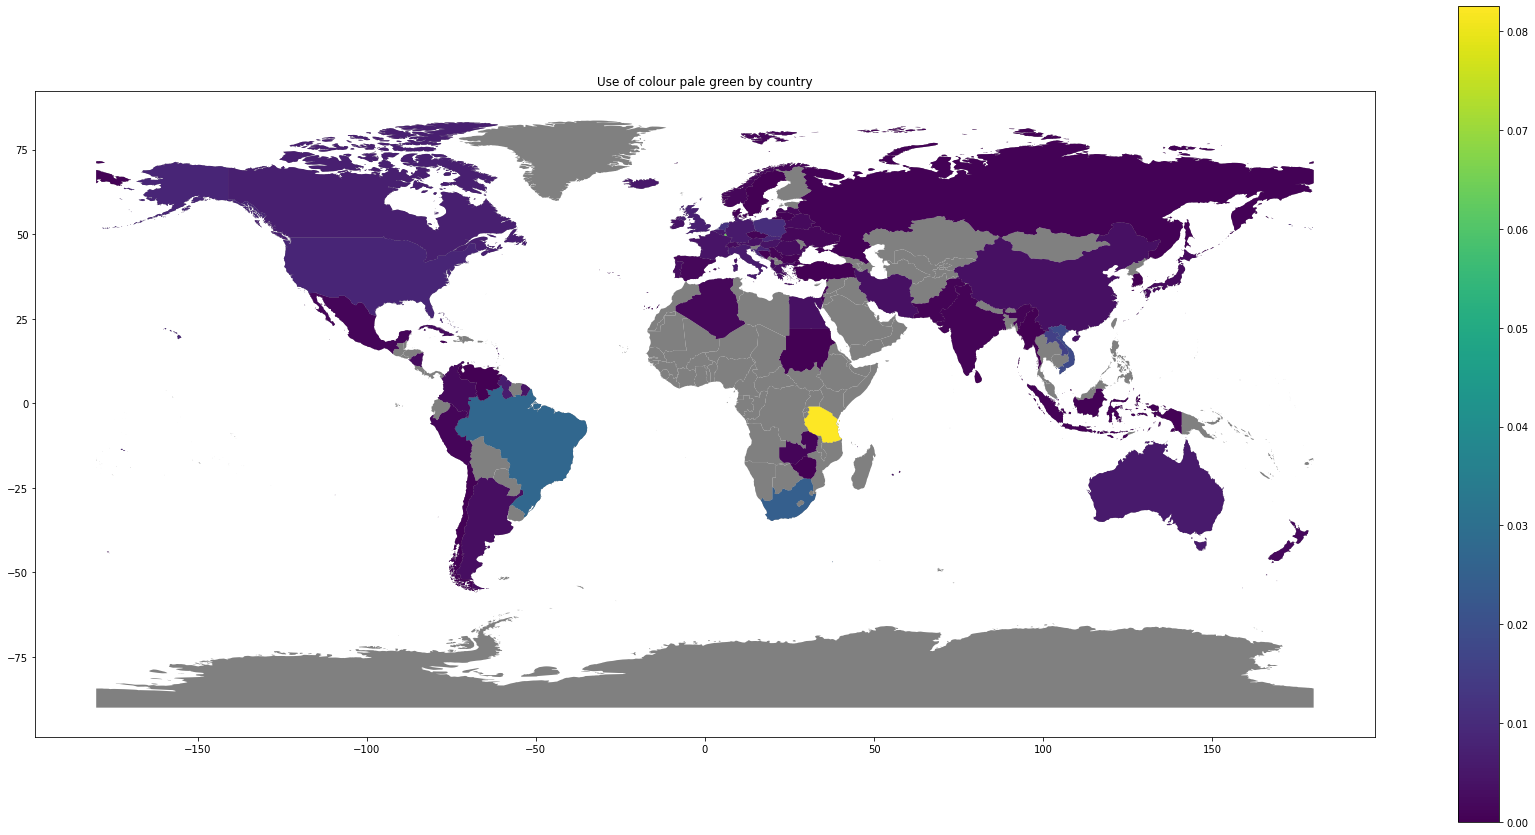

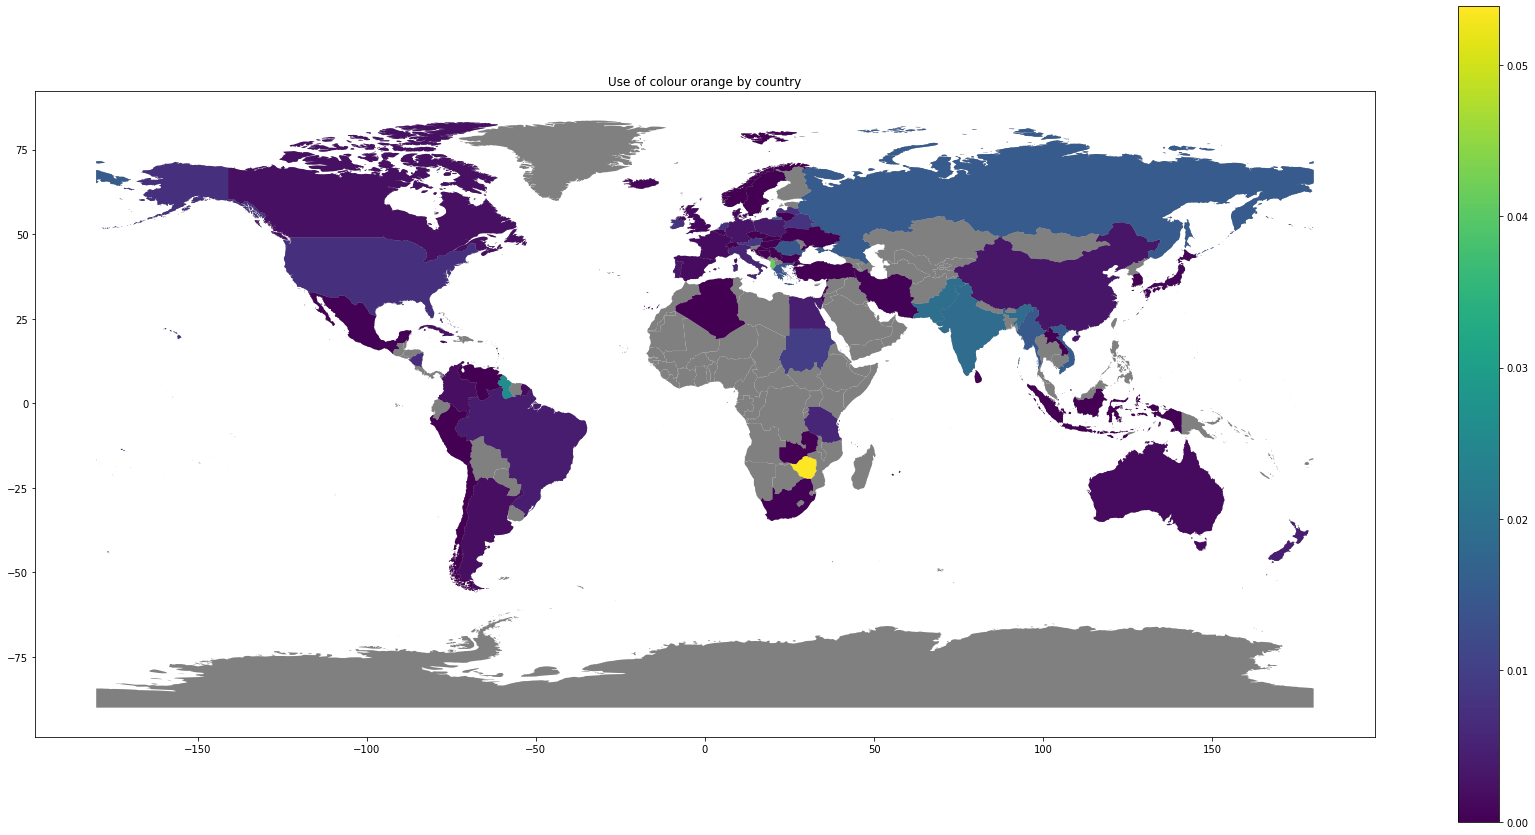

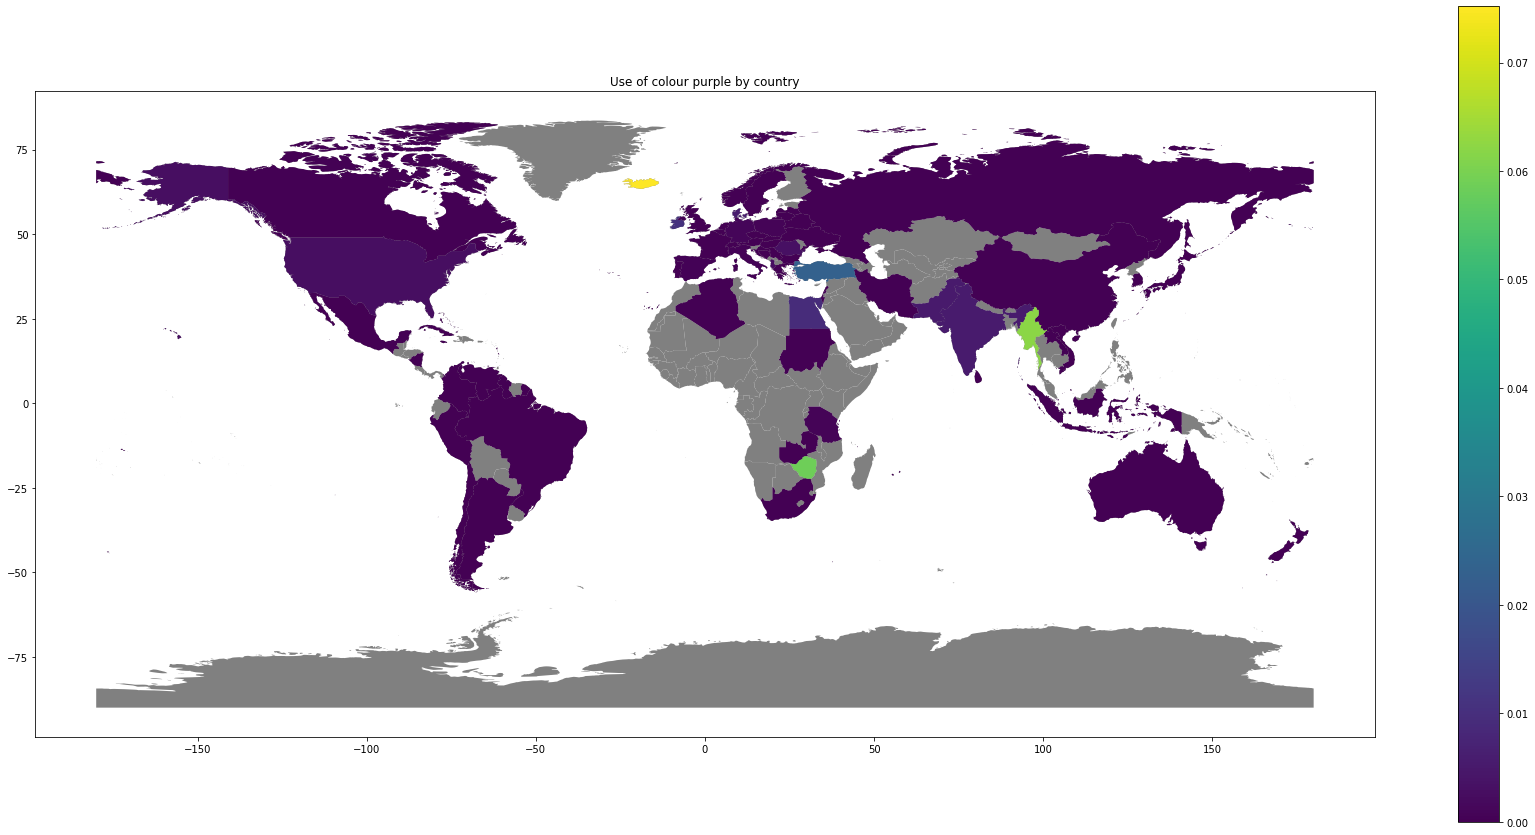

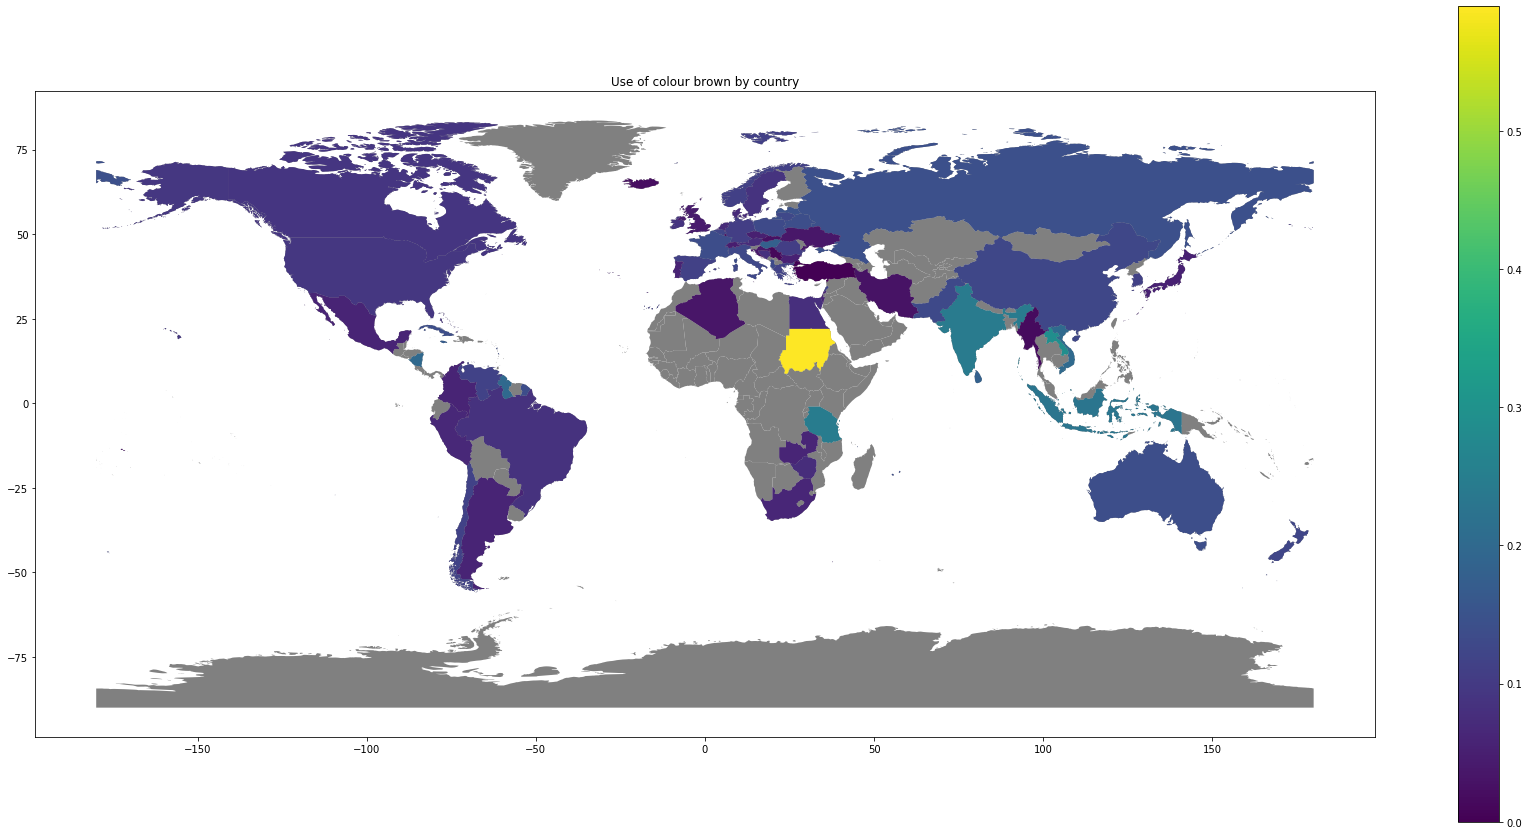

In [53]:
for col in colour_pct:
    f, ax = plt.subplots(1, figsize=(30, 15))
    plt.title(f'Use of colour {col[:-4]} by country')
    ax = country_names.plot(ax = ax, color='gray')
    ax = artworks_grouped_country.plot(column=col,ax = ax, legend=True, legend_kwds={'loc': 'lower right'}, cmap='viridis')
    plt.show()

In [54]:
artworks_grouped_country['main_colour'] = artworks_grouped_country[artworks_colours.columns[:13]].idxmax(axis=1)
artworks_grouped_country

black          gray         white        blue  \
countryOfBirth                                                         
Albania         26205.000000   7854.500000    319.500000   30.500000   
Algeria          1843.000000  25013.000000      2.000000    0.000000   
Argentina        3407.414894  10734.202128  12315.446809  191.000000   
Australia        4906.909091  14939.757576  11308.515152   76.621212   
Bahamas          2177.846154   8235.000000  13667.329670  461.296703   
...                      ...           ...           ...         ...   
Venezuela        7203.666667  17572.166667   9969.833333    0.000000   
Vietnam         14430.000000  14131.400000   2102.400000    3.200000   
Zambia           4756.900000  27809.900000   3373.500000  123.300000   
Zimbabwe         4337.000000  10720.600000  19583.200000    0.000000   
Österreich       5174.875000   7549.464286  16196.553571  107.892857   

                 light blue          red          pink       yellow  \
countryOfBirth                                                        
Albania          359.500000  2957.000000    654.000000  3093.000000   
Algeria            0.000000     0.000000   6709.000000     0.000000   
Argentina        270.297872   223.601064  15133.611702    24.617021   
Australia        500.181818   357.757576  11986.136364    42.030303   
Bahamas         1020.175824   970.208791  15015.296703    35.043956   
...                     ...          ...           ...          ...   
Venezuela          0.000000     0.000000  10275.333333     0.000000   
Vietnam           97.600000   589.200000   8068.000000   636.000000   
Zambia          3060.500000     2.800000  11435.300000     0.000000   
Zimbabwe         724.000000   244.300000   6299.900000    96.600000   
Österreich        41.321429  2326.857143  11151.410714   262.446429   

                     green  pale green  ...  yellow_pct  green_pct  \
countryOfBirth                          ...                          
Albania          10.000000  137.500000  ...    0.061643   0.000199   
Algeria           0.000000   54.000000  ...    0.000000   0.000000   
Argentina        17.085106  151.526596  ...    0.000489   0.000345   
Australia       122.257576  291.757576  ...    0.000825   0.002570   
Bahamas          19.637363  442.010989  ...    0.000624   0.000497   
...                    ...         ...  ...         ...        ...   
Venezuela         0.000000    6.833333  ...    0.000000   0.000000   
Vietnam          43.800000  990.600000  ...    0.011895   0.000728   
Zambia           38.800000   57.700000  ...    0.000000   0.000687   
Zimbabwe          2.100000    2.300000  ...    0.001850   0.000040   
Österreich      773.785714  159.125000  ...    0.005158   0.015345   

                pale green_pct  orange_pct  purple_pct  brown_pct  \
countryOfBirth                                                      
Albania               0.002740    0.041155    0.002740   0.131504   
Algeria               0.001551    0.000000    0.000000   0.034323   
Argentina             0.003192    0.002058    0.000044   0.057950   
Australia             0.005546    0.001662    0.000249   0.140528   
Bahamas               0.008319    0.004925    0.000187   0.088445   
...                        ...         ...         ...        ...   
Venezuela             0.000135    0.000000    0.000000   0.116394   
Vietnam               0.018516    0.015507    0.000004   0.202073   
Zambia                0.001079    0.000006    0.000006   0.061503   
Zimbabwe              0.000044    0.053868    0.058489   0.074200   
Österreich            0.003685    0.008520    0.000188   0.074108   

                             TYPE        ADMIN  \
countryOfBirth                                   
Albania         Sovereign country      Albania   
Algeria         Sovereign country      Algeria   
Argentina       Sovereign country    Argentina   
Australia                 Country    Australia   
Bahamas         Sovereign country  The Bahamas   
...

Additionally, the most used colour pre country is computed and displayed below. The countries with no data appear as white with blue hatch on the map. 

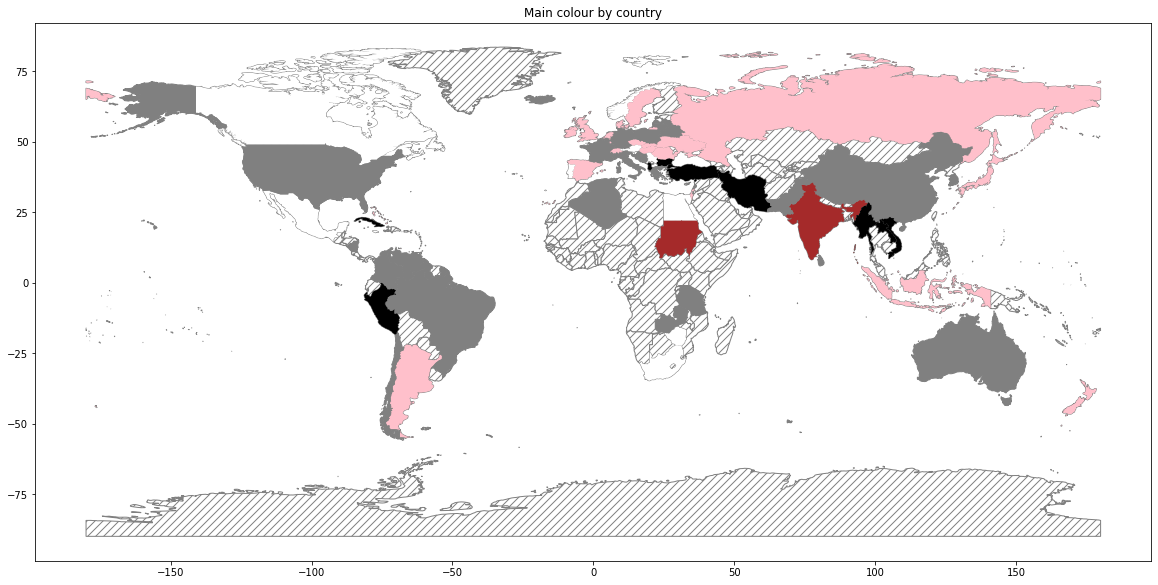

In [55]:
fig, ax = plt.subplots(figsize=(20,10))
country_names.plot(ax=ax, color='white', edgecolor='grey', hatch= "///")
plt.title(f'Main colour by country')
for i in range(0, artworks_grouped_country.shape[0]):
    artworks_grouped_country.iloc[i:i+1].plot(ax=ax, color=artworks_grouped_country['main_colour'].iloc[i], legend=True)
plt.show()

Looking at the map of the most common colour used by country, it appears that most countries use pink and grey in majority. However, this might not be due to the real colour distribution of images: two obvious reasons for this result appear clearly when looking at the artwork images. 

In [56]:
def print_img_col(imgn):
    colours_pos=np.arange(1,14,1)
    img = mpimg.imread(f'img/{imgn}.jpg')
    fig, ax = plt.subplots(1, 2, figsize=(20,10))
    ax[0].imshow(img)

    ax[1].barh(colours_pos, width=artworks_colours[colour_pct].loc[imgn].tolist(), tick_label=colour_pct)
    # plt.legend(patches, colour_pct, loc="best")
    fig.suptitle(f"Example for artwork {artworks_colours['title'].loc[imgn]}")
    plt.show()

The image displayed below is the picture for the artwork ‘marine construction’. Looking at the colour distribution computed for this image, gray appears to dominate this picture. However, the gray found is simply the background against which the artwork was displayed. It therefore appears that for artworks other than picture-based, such as sculptures or installations, the colour distribution will not accurately reflect the colours of the artworks, but rather of the environment in which they are shown.

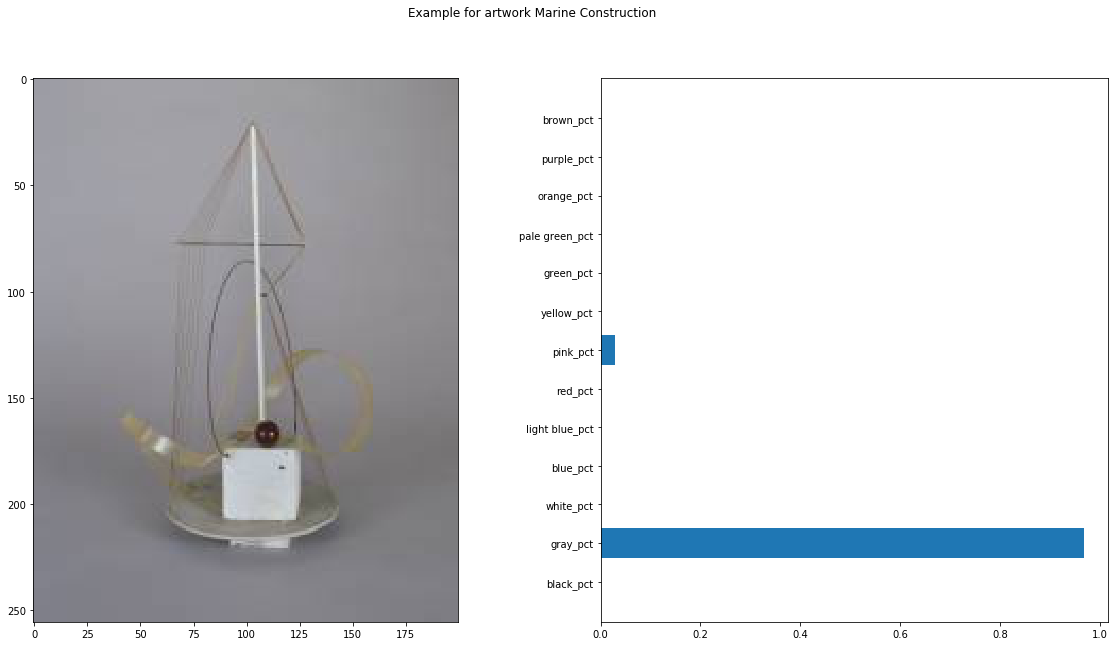

In [57]:
print_img_col(67305)

Secondly, some pixels might be misclassified, thus causing inaccuracies in the colour classification table. Looking at the table below, gray emerges as the major colour of the artwork, making up over 90% of the picture. However, a visual check of the image reveals that other colours, such as blue, yellow and green are present in the work, and not recognised by the algorithm. The method of assigning colour might be the source of this misclassification: the values chosen to assign colours was the RGB encoding of each pixel. However, the RGB system might not accurately reflect how the human eye perceives colour, and thus the smallest geometrical distance in the RGB space might not output the closest perceived colour.

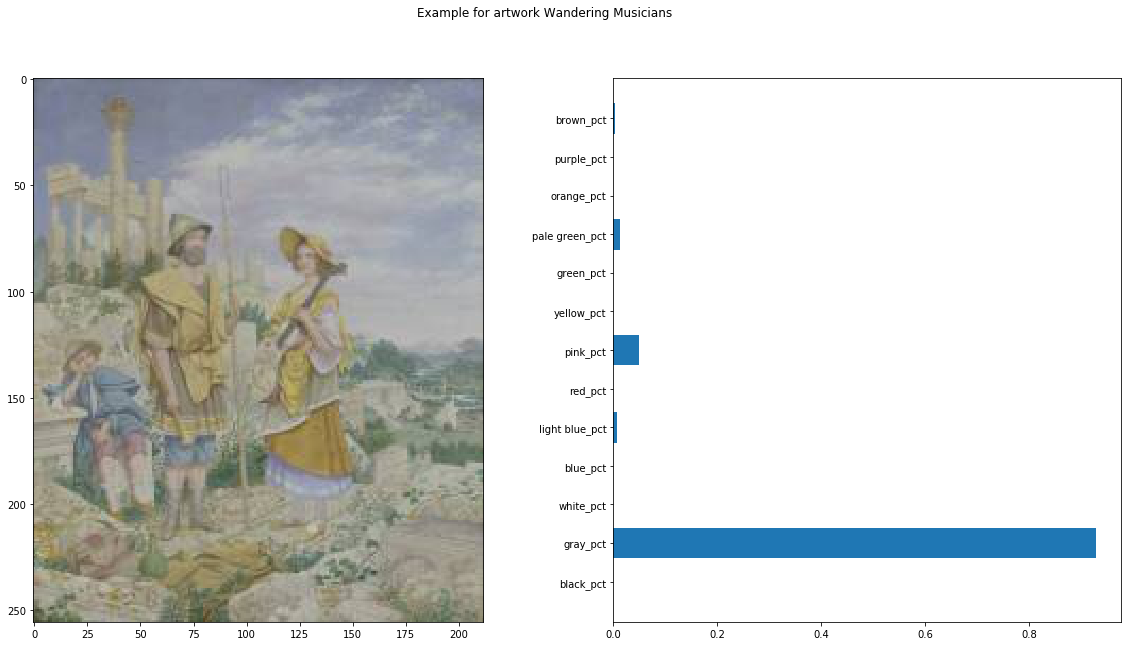

In [58]:
print_img_col(88032)

Additionally, gray is the colour at the center of the RGB space, with coordinates (128, 128, 128), as shown in the figure below. Therefore, many colours that do not appear gray to the eye can still be assigned the label gray if they are close to the center of the RGB space.

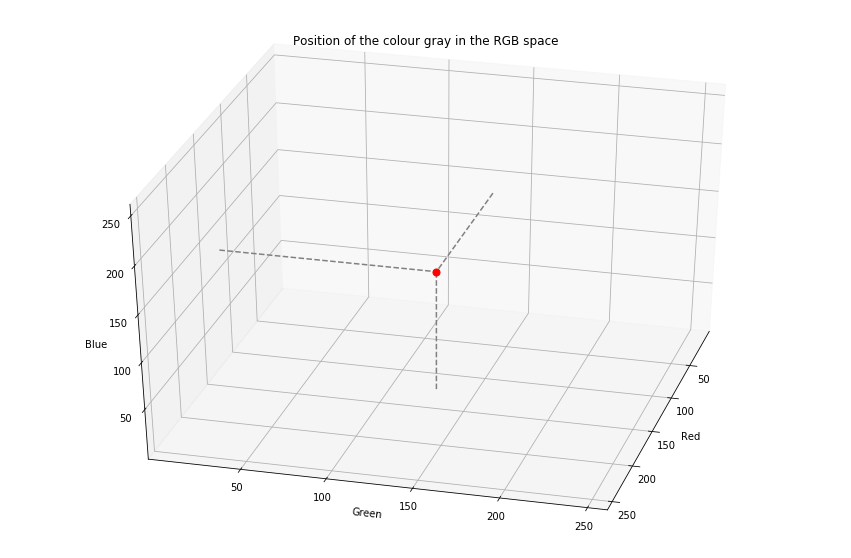

In [59]:
fig = plt.figure(figsize=(15,10))
axis = fig.add_subplot(1, 1, 1, projection="3d")

axis.plot(np.linspace(0, COLOURS_CHOSEN['gray'][0], 100), np.linspace(COLOURS_CHOSEN['gray'][1], COLOURS_CHOSEN['gray'][1], 100), np.linspace(COLOURS_CHOSEN['gray'][2], COLOURS_CHOSEN['gray'][2], 100), c='gray', linestyle='--')
axis.plot(np.linspace(COLOURS_CHOSEN['gray'][0], COLOURS_CHOSEN['gray'][0], 100), np.linspace(0, COLOURS_CHOSEN['gray'][1], 100), np.linspace(COLOURS_CHOSEN['gray'][2], COLOURS_CHOSEN['gray'][2], 100), c='gray', linestyle='--')
axis.plot(np.linspace(COLOURS_CHOSEN['gray'][0], COLOURS_CHOSEN['gray'][0], 100), np.linspace(COLOURS_CHOSEN['gray'][1], COLOURS_CHOSEN['gray'][1], 100), np.linspace(0, COLOURS_CHOSEN['gray'][2], 100), c='gray', linestyle='--')

axis.scatter(COLOURS_CHOSEN['gray'][0], COLOURS_CHOSEN['gray'][1], COLOURS_CHOSEN['gray'][2], c="red", marker="o", s=50)

axis.set_xlabel("Red")
axis.set_ylabel("Green")
axis.set_zlabel("Blue")
axis.set_ylim([1, 256])
axis.set_xlim([1, 256])
axis.set_zlim([1, 256])
axis.view_init(35, 15)
axis.set_title('Position of the colour gray in the RGB space')
plt.show()

As an attempt at solving the first problem mentioned, a subset of the dataset containing only painting, drawings and photographs can be selected. To do so, a set of keywords relating to painting and photography is selected and searched in the medium column. The rows that contain none of these keywords are filtered out. 


In [60]:
searchfor = ['oil', 'watercolour', 'gouache', 'acrylic', 'ink', 'tempera', 'painted', 'collage', 'crayon']
paintings = artworks_colours.loc[artworks_colours['medium'].str.lower().str.contains('|'.join(searchfor))]
paintings

black   gray  white  blue  light blue    red   pink  yellow  green  \
id                                                                           
1035    22352  27530     11     0           0      0   5376       0      0   
1068      801  22345   8702     0           0     58   6188       0    501   
1075        0   2533  39192     0         214      0   3616       0      0   
1079       50    823    994     0           0      0  46773       0      0   
1699        2  35036     45     0           0      0   1013       0      0   
...       ...    ...    ...   ...         ...    ...    ...     ...    ...   
121194   1658  14921   2132     0          17    189  21183       0      0   
121195   1338  33168   3111  1296          21    529    677       0    279   
121196   2632  28876   2739     0           1      2   1817       0      1   
121197     27  35887   2262     0          13    675   4578       0      0   
121198    599  12200   1333     0           0  12345   1901       0      9   

        pale green  ...  blue_pct  light blue_pct   red_pct  pink_pct  \
id                  ...                                                 
1035             0  ...  0.000000        0.000000  0.000000  0.086066   
1068             2  ...  0.000000        0.000000  0.001434  0.152987   
1075             0  ...  0.000000        0.004696  0.000000  0.079354   
1079           452  ...  0.000000        0.000000  0.000000  0.951599   
1699           224  ...  0.000000        0.000000  0.000000  0.027672   
...            ...  ...       ...             ...       ...       ...   
121194           5  ...  0.000000        0.000371  0.004124  0.462269   
121195           0  ...  0.026786        0.000434  0.010933  0.013992   
121196         328  ...  0.000000        0.000021  0.000042  0.037753   
121197          14  ...  0.000000        0.000290  0.015067  0.102188   
121198           0  ...  0.000000        0.000000  0.255146  0.039290   

       yellow_pct green_pct pale green_pct  orange_pct purple_pct brown_pct  
id                                                                           
1035          0.0  0.000000       0.000000    0.000000   0.000000  0.115186  
1068          0.0  0.012386       0.000049    0.000049   0.000000  0.045713  
1075          0.0  0.000000       0.000000    0.000000   0.000000  0.000285  
1079          0.0  0.000000       0.009196    0.000000   0.000000  0.001221  
1699          0.0  0.000000       0.006119    0.000000   0.000000  0.007867  
...           ...       ...            ...         ...        ...       ...  
121194        0.0  0.000000       0.000109    0.000000   0.000000  0.124804  
121195        0.0  0.005766       0.000000    0.000000   0.000000  0.164621  
121196        0.0  0.000021       0.006815    0.000000   0.000000  0.243767  
121197        0.0  0.000000       0.000313    0.000000   0.000000  0.030000  
121198        0.0  0.000186       0.000000    0.000000   0.000041  0.413256  

[10199 rows x 59 columns]

When removing the gray an plotting the colours again, pink emerges as the major colour in most countries.

In [61]:
paintings_grouped_country = paintings.groupby('countryOfBirth').mean()
paintings_grouped_country= paintings_grouped_country.join(final_countries_df.set_index('final_country'))
paintings_grouped_country = gpd.GeoDataFrame(paintings_grouped_country, geometry='geometry')
paintings_grouped_country['main_colour'] = paintings_grouped_country[['black', 'white', 'blue', 'light blue', 'red', 'pink', 'yellow',
       'green', 'pale green', 'orange', 'purple', 'brown']].idxmax(axis=1)
paintings_grouped_country

black          gray         white          blue  \
countryOfBirth                                                           
Argentina        3979.200000  12562.800000   9575.000000    676.000000   
Australia        5884.200000  17146.300000   4678.300000     14.200000   
Bahamas          1719.000000   6807.500000  18757.000000      0.000000   
Belarus         10588.400000  14312.600000    216.000000    116.400000   
België          12821.153846  10893.192308   6154.000000   1327.961538   
Brasil           3760.964286  15585.714286     16.392857      0.178571   
Canada           4994.413793   9225.758621  21846.413793     15.482759   
Chile            1337.000000  22124.333333   4931.333333      0.000000   
China            7715.250000  15157.500000   9744.666667      2.500000   
Czechia          9901.000000  11620.000000  12212.000000      0.000000   
Danmark          1803.666667  26516.000000    152.666667      0.333333   
Deutschland      5577.246914  16370.156379   3838.880658     65.288066   
Egypt            1260.916667  22728.166667   5419.916667     96.166667   
España           6132.967742  13648.516129   6272.645161      3.516129   
France           4850.011628  23280.337209   1452.476744     84.546512   
Greece           2981.000000   7110.000000   9639.500000      0.000000   
Guyana           2436.333333  22177.666667     13.500000   1024.166667   
Iceland          4423.000000  14295.000000   3513.000000  11230.000000   
India            9916.681818  16601.954545   2837.181818      6.545455   
Iran            21892.333333   5234.000000  22348.666667     51.666667   
Ireland          8846.329268   7751.817073   8088.426829     39.085366   
Isle of Man     20058.000000  12280.000000   1359.000000      0.000000   
Israel           3941.500000  12439.250000   8742.250000      0.000000   
Italia          11342.986111  16015.277778   2519.597222     56.180556   
Japan            3458.166667  14650.333333   2241.833333      0.833333   
Latvia          24748.928571   4518.857143    314.214286      0.000000   
Lebanon          5353.500000  31181.000000    506.500000    655.000000   
Lithuania       23849.000000   3836.000000   8203.000000      0.000000   
Luxembourg        515.000000   8864.000000  12867.000000   1477.000000   
Magyarország    11105.250000  11692.750000   1261.250000      0.000000   
Montserrat       4671.333333   3548.000000  30728.000000      0.000000   
Myanmar         17021.000000   1811.000000    828.000000  25259.000000   
México             18.000000  10322.000000   2533.000000      0.000000   
Nederland        5565.500000  14269.714286   7969.285714     37.357143   
New Zealand       521.000000   8945.750000    145.000000      0.000000   
Pakistan         4652.700000  12395.100000   7743.300000     44.800000   
Perú             6316.500000   8335.500000  17809.500000      0.000000   
Poland          11524.000000  18062.823529   2567.705882      1.176471   
Portugal         4054.903846   8226.346154  27367.480769     30.038462   
Romania         13513.000000  17203.000000      0.000000      0.000000   
Russia           3620.905109  16164.481752   3719.832117      8.379562   
Schweiz          2875.445455  13590.054545    906.172727      7.536364   
Slovakia         4094.500000  12187.800000   3237.300000      3.200000   
South Africa     3741.952381  10445.857143  15877.333333      6.142857   
Sudan            4144.000000  10369.000000      0.000000      0.000000   
Sweden          11121.500000  14499.250000   4622.000000      0.000000   
Tanzania         2183.000000  18605.000000    749.000000    116.000000   
United Kingdom   5067.759401  15163.570122   3581.380386     49.861698   
United States    8259.073394  13830.954128   5411.064220    384.412844   
Venezuela        6202.000000  14348.500000   7880.500000      0.000000   
Vietnam         14430.000000  14131.400000   2102.400000      3.200000   
Zimbabwe         8564.333333  12272.000000  20280.000000      0.000000   
Österreich       6632.10344

In [62]:
paintings_grouped_country['main_colour'].loc[paintings_grouped_country['main_colour'] == 'light blue'] = 'paleturquoise'

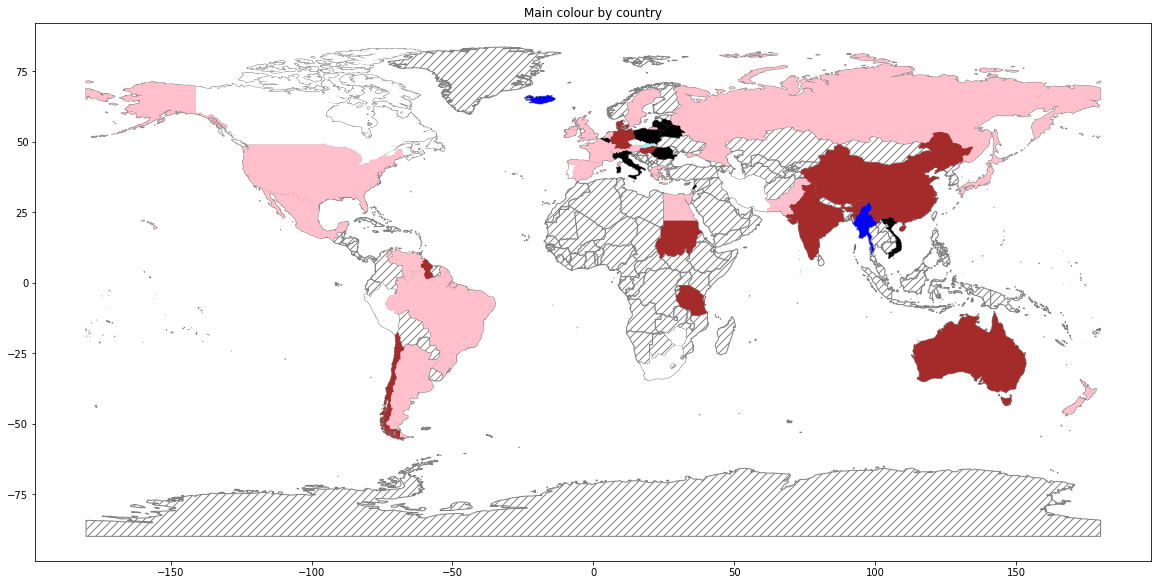

In [63]:
fig, ax = plt.subplots(figsize=(20,10))
country_names.plot(ax=ax, color='white', edgecolor='grey', hatch= "///")
plt.title(f'Main colour by country')
for i in range(0, paintings_grouped_country.shape[0]):
    paintings_grouped_country.iloc[i:i+1].plot(ax=ax, color=paintings_grouped_country['main_colour'].iloc[i], legend=True)
plt.show()

However, a similar observation can be done for the colour pink. The display below shows that many pixels by be classified as pink, but are closer to beige.


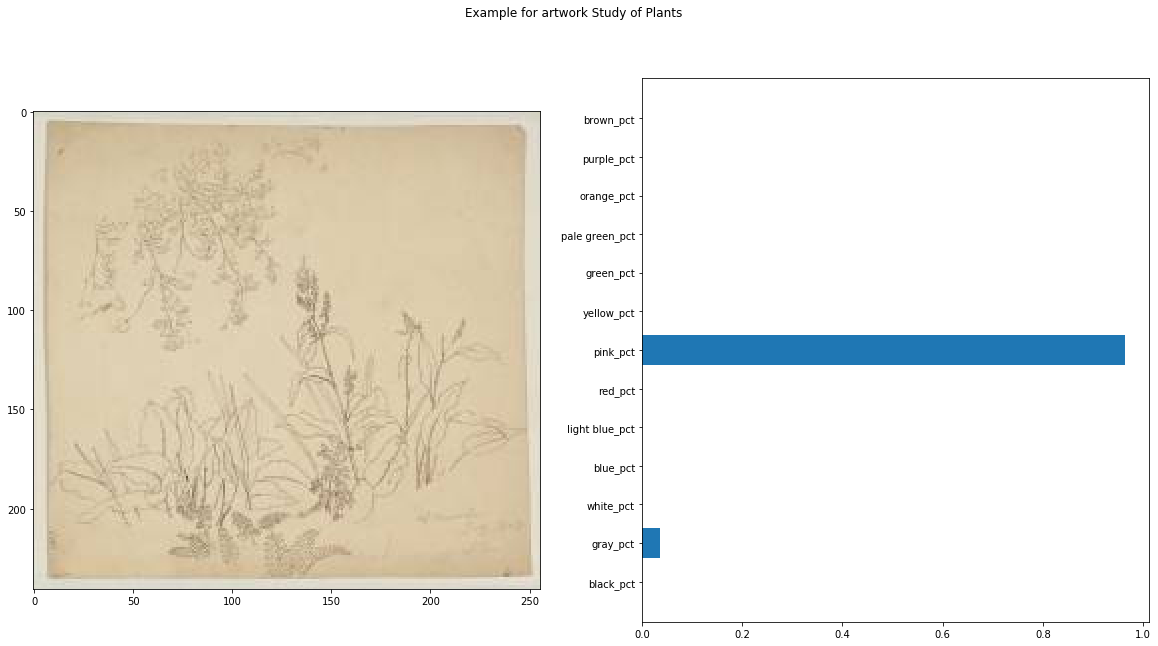

In [64]:
print_img_col(23225)

Therefore, removing colours that apear misclassified would remove a sigificant part of the data. Therefore, all colour categories will be kept for the rest of the analysis.

## ANALYSIS

In order to find patterns and clusters, unsupervised analysis is undertaken. K-means clustering and DBscan are chosen as they allow for fast results. Hierarchical clustering was attempted, but due to memory constraints it does not scale well and is therefore not the most adapted algorithm in this case (Kriegel et al, 2017). First, the data is scaled. Only the numerical columns regarding colour distribution year of birth and year of acquisition are kept for the clustering.

In [65]:
paintings['yearOfBirth'].loc[paintings['yearOfBirth'] == ''] = 1665

C:\Users\margo\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [66]:
scaled = preprocessing.scale(paintings[['black', 'gray', 'white', 'blue', 'light blue', 'red',
       'pink', 'yellow', 'green', 'pale green', 'orange', 'purple', 'brown',
       'total', 'acquisitionYear', 'yearOfBirth']])

#### DBSCAN

The first algorithm tested in this analysis is DBscan. Two main hyperparameters can be changed in this case: eps, which is the maximum distance between two points for them to be considered in the same cluster, and n_sample, which is the minimum number of points necessary to form a cluster. In order to observe the performance of the model with combinations of these two parameters, 15 different sets of randomly selected values for the two parameters are used. The final set of hyperparameters is selected from observation of the different results. 


In [67]:
def select_random(tested, list1, list2):
    tmp_eps = random.choice(list1)
    tmp_sample = random.choice(list2)
    if [tmp_eps, tmp_sample] in tested:
        print('Trying again with another set of parameters')
        return(select_random(tested, list1, list2))
    else:
        return(tmp_eps, tmp_sample)

def random_search(dataset, scaled):
    eps_list = np.arange(0.5, 0.8, 0.2)
    min_sample_list = np.arange(4,25,2)
    tested=[]
    sil_scores = []
    best_score={'silouhette':-1}
    for i in range(15):
        print(f'Test {i+1}')
        tmp_eps, tmp_sample = select_random(tested, eps_list, min_sample_list)
        tested.append([tmp_eps, tmp_sample])
        print(f'Eps value: {tmp_eps}, min sample value: {tmp_sample}')
        dbscan = DBSCAN(eps=tmp_eps, min_samples=tmp_sample)
        tmp = dataset
        dbscan.fit(scaled)
        tmp=tmp.assign(label = dbscan.labels_)
        sil_score = metrics.silhouette_score(scaled, dbscan.labels_)
        sil_scores.append(sil_score)
        print(f"the silouhette score is {sil_score}")
        if sil_score > best_score['silouhette']:
            best_score['silouhette'] = sil_score
            best_score['eps'] = tmp_eps
            best_score['min_sample'] = tmp_sample
    tested = np.array(tested)
    returns = [[sil_scores[i], tested[i,0], tested[i,1]] for i in range(len(sil_scores))]
    best = best_score['silouhette']
    eps = best_score['eps']
    sample = best_score['min_sample']
    print(f"The best silouette score is {best}, with eps {eps} and min sample value {sample}")
    return(best_score, returns)

In [68]:
best_score, values = random_search(paintings, scaled)

Test 1
Eps value: 0.5, min sample value: 4
the silouhette score is -0.42906801733698735
Test 2
Eps value: 0.7, min sample value: 22
the silouhette score is -0.028249030490589144
Test 3
Eps value: 0.5, min sample value: 10
the silouhette score is -0.27445110362320524
Test 4
Eps value: 0.5, min sample value: 18
the silouhette score is -0.2179063812888205
Test 5
Trying again with another set of parameters
Eps value: 0.7, min sample value: 16
the silouhette score is -0.02832354502908562
Test 6
Eps value: 0.5, min sample value: 20
the silouhette score is -0.18084549349733844
Test 7
Eps value: 0.7, min sample value: 8
the silouhette score is -0.11816563920130468
Test 8
Eps value: 0.7, min sample value: 4
the silouhette score is -0.29318944926310486
Test 9
Eps value: 0.5, min sample value: 12
the silouhette score is -0.22671318774560204
Test 10
Trying again with another set of parameters
Trying again with another set of parameters
Eps value: 0.5, min sample value: 22
the silouhette score is -

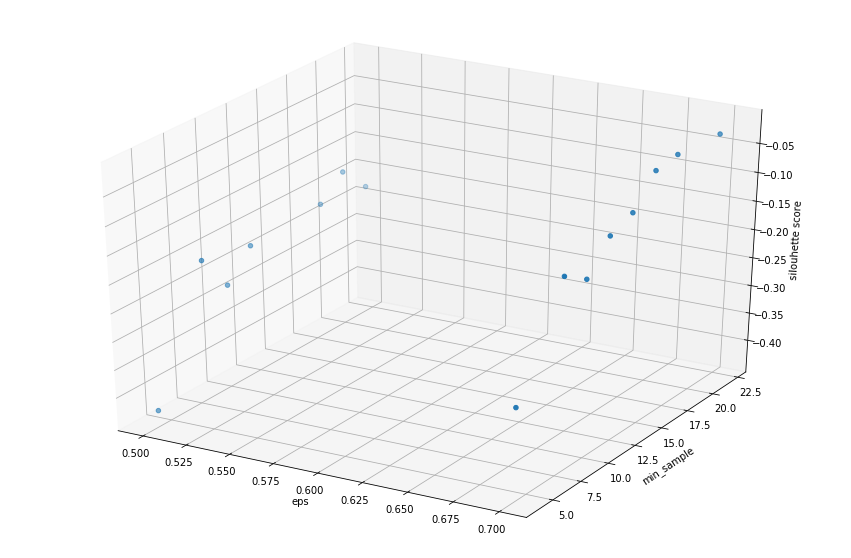

In [69]:
values = np.array(values)
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(values[:, 1], values[:, 2], values[:, 0], marker='o')

ax.set_xlabel('eps')
ax.set_ylabel('min_sample')
ax.set_zlabel('silouhette score')


plt.show()

This methodology is first followed for the dataset containing paintings only. However, after following this process for the full dataset, it appears that the best results are obtained when considering the entire data. Therefore, the analysis from this point will focus on the results obtained from the full dataset.

In [70]:
scaled = preprocessing.scale(artworks_colours[['black', 'gray', 'white', 'blue', 'light blue', 'red',
       'pink', 'yellow', 'green', 'pale green', 'orange', 'purple', 'brown',
       'total']])

Note: the next cell takes approximately 20 minutes to run. The results of this cell led to the selecion of the best hyperparamters, which were then hard coded in the notebook. Therefore, running the next five cells is not essential to the functioning of the notebook and can be skipped to save time.

In [71]:
best_score_all_artworks, values_all_artworks = random_search(artworks_colours, scaled)

Test 1
Eps value: 0.7, min sample value: 20
the silouhette score is 0.30538548870003657
Test 2
Eps value: 0.5, min sample value: 4
the silouhette score is -0.4072015704883737
Test 3
Trying again with another set of parameters
Eps value: 0.5, min sample value: 20
the silouhette score is 0.05067180566042118
Test 4
Eps value: 0.5, min sample value: 14
the silouhette score is 0.11755502534518425
Test 5
Eps value: 0.7, min sample value: 12
the silouhette score is 0.02264021836760388
Test 6
Eps value: 0.7, min sample value: 22
the silouhette score is 0.26263692775470066
Test 7
Eps value: 0.5, min sample value: 24
the silouhette score is -0.018714804587971673
Test 8
Eps value: 0.5, min sample value: 16
the silouhette score is 0.02166859667438557
Test 9
Eps value: 0.5, min sample value: 18
the silouhette score is -0.03843204170695017
Test 10
Eps value: 0.5, min sample value: 22
the silouhette score is -0.0356433063197821
Test 11
Eps value: 0.5, min sample value: 10
the silouhette score is -0.2

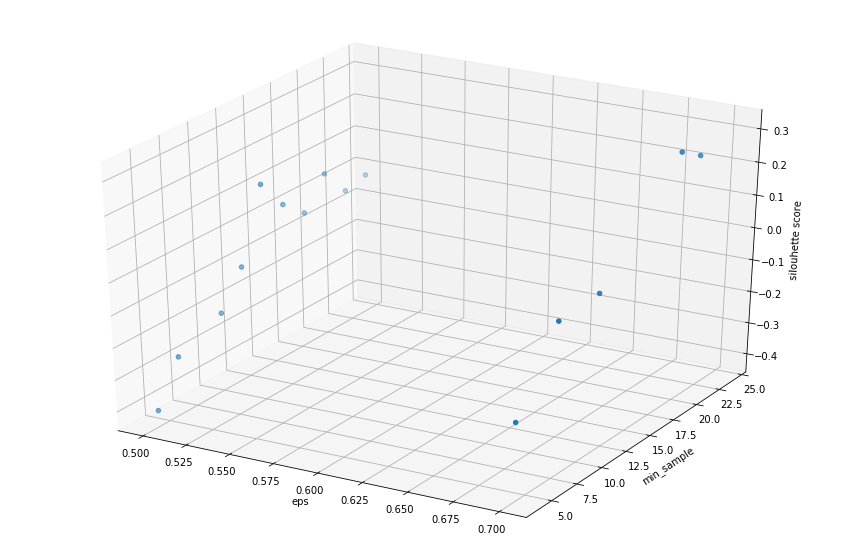

In [72]:
values_all_artworks = np.array(values_all_artworks)
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(values_all_artworks[:, 1], values_all_artworks[:, 2], values_all_artworks[:, 0], marker='o')

ax.set_xlabel('eps')
ax.set_ylabel('min_sample')
ax.set_zlabel('silouhette score')


plt.show()

In [73]:
values_all_artworks_df = pd.DataFrame(values_all_artworks, columns=['silhouette score', 'eps', 'min_samples'])

In [74]:
values_all_artworks_df

silhouette score  eps  min_samples
0           0.305385  0.7         20.0
1          -0.407202  0.5          4.0
2           0.050672  0.5         20.0
3           0.117555  0.5         14.0
4           0.022640  0.7         12.0
5           0.262637  0.7         22.0
6          -0.018715  0.5         24.0
7           0.021669  0.5         16.0
8          -0.038432  0.5         18.0
9          -0.035643  0.5         22.0
10         -0.212581  0.5         10.0
11         -0.275599  0.5          6.0
12          0.013203  0.7          8.0
13         -0.103570  0.5         12.0
14         -0.214434  0.7          4.0

From the results of the different sets of parameters in the graphs displayed, the eps value is chosen to be 0.7 and the min_sample value is chosen to be 16.

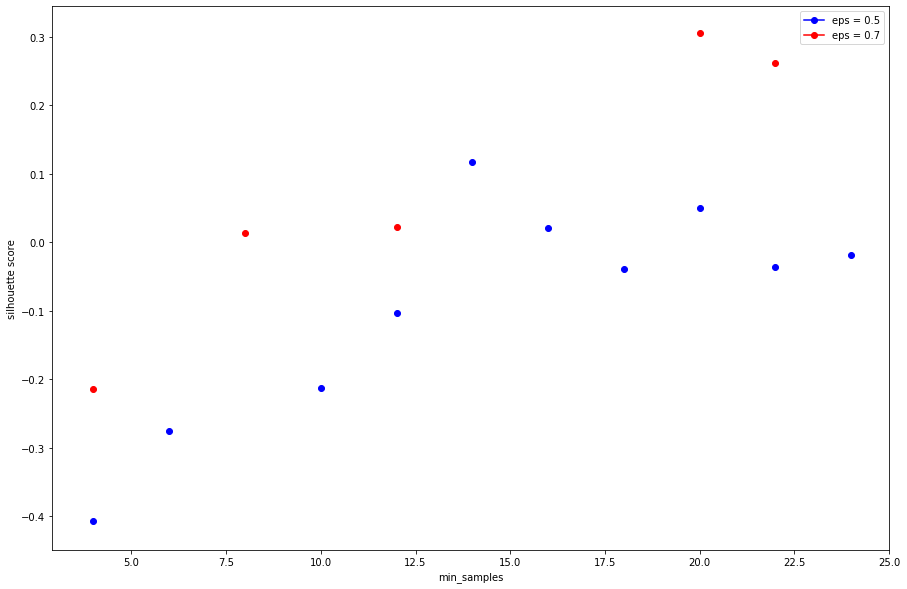

In [75]:
fig, ax = plt.subplots(figsize=(15,10))

ax.scatter(values_all_artworks_df.loc[values_all_artworks_df['eps']==0.5]['min_samples'], values_all_artworks_df.loc[values_all_artworks_df['eps']==0.5]['silhouette score'], marker='o', color='b')
ax.scatter(values_all_artworks_df.loc[values_all_artworks_df['eps']==0.7]['min_samples'], values_all_artworks_df.loc[values_all_artworks_df['eps']==0.7]['silhouette score'], marker='o', color='r')
legend_elements = [Line2D([0], [0], marker='o', color='b', label='eps = 0.5'),
                   Line2D([0], [0], marker='o', color='r', label='eps = 0.7')
                  ]

ax.legend(handles=legend_elements)

ax.set_xlabel('min_samples')
ax.set_ylabel('silhouette score')


plt.show()

In [71]:
dbscan = DBSCAN(eps=0.7, min_samples=16)
dbscan.fit(scaled)


DBSCAN(algorithm='auto', eps=0.7, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=16, n_jobs=None, p=None)

In [72]:
artworks_colours_assigned=artworks_colours.assign(label = dbscan.labels_)
np.unique(artworks_colours_assigned['label'].values)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8], dtype=int64)

In [73]:
artworks_colours_assigned.loc[artworks_colours_assigned['label']==1]

black  gray  white  blue  light blue  red  pink  yellow  green  \
id                                                                      
98183  46449  2709     19     0          80    0   104       0      0   
98465  48398   855    934     0           0    0  1352       0      0   
98468  44361  1469     32     0           0    0  5466       0      0   
95725  50562  1071      0     0           0    0     0       0      0   
97280  47032  3044   1465     0           0    0  2074       0      0   
12388  43882  1574      0     0           0    0     0       0      0   
12389  48847    23      0     0           0    0     0       0      0   
13360  50198  1149      0     0           0  501   142      12      0   
12399  45876  2312      0     0           0    0     0       0      0   
12400  49338  1425      0     0           0    0   822       0      0   
13841  43328  2235      0     0           0  401     1       0      0   
12173  49382  1149      0     0           0  128   426       8     84   
12736  44346  2398     20     0          39  202  1578      21      0   
13911  43311  7059      1     0           0   32   799       0      0   
13868  44861  2074      0     0           0  443   184       0      0   
15993  43216  1838      0     0           0   69     7       0      0   
12278  47350  1853      0     0           1  784  1445       3      0   
15793  44459  2724      8     0           0   42  1518       0      0   
12415  45263  2600      0     0           0    0     7       0    216   
15800  45761   122      0     0           0  246     0       0      0   
15579  47575   425   2366     0           0    0   264       0      0   
15580  46758   335   2711     0           0    0   260       0      0   
15581  47533   300   2740     0           0    0   243       0      0   
14567  48128     0      0     0           0    0     0       0      0   
15656  45485   324   3008     0           0    0   221       0      0   
13315  46847   330   2504     0           0    0  5038       0      0   
20982  44927  2995      2     0          15  349   469       2     95   
21016  49959  1013      0     0           0    0     0       0    377   
21017  48125  2001      0     0           0    0    22       0      0   
21890  48622   992      0     0           0    0     0       0      0   
21889  42542  2548     44     0           0    0   314       0      0   
26079  44995  1859      2     0           0    0    53       0      1   
12607  48580  2466      0     0           0  220    31       1      0   
14377  51836  1768      0     0           0    0     0       0    166   
14588  48678   206      0     0           0    0     0       0    268   
13623  46070  3222    275     0           0    0   800       0      0   
20268  44379  5217      0     0           0   21   130       0      0   
20726  49066   661   1509     0           5    5   916       0      8   
66717  49626   467     81     0           0    0   162       0      0   
90135  48313    36      0     0           0    0     0       0      1   
96924  45900  1608      0     0           0    0     0       0      0   
97082  43179  1786    103     0           4    0   312       0      1   
98980  47254   549    532     0         222    0    13       0      5   

       pale green  ...  light blue_pct   red_pct  pink_pct  yellow_pct  \
id                 ...                                                   
98183          11  ...        0.001603  0.000000  0.002083    0.000000   
98465           3  ...        0.000000  0.000000  0.026016    0.000000   
98468          43  ...        0.000000  0.000000  0.105701    0.000000   
95725           0  ...        0.000000  0.000000  0.000000    0.000000   
97280          29  ...        0.000000  0.000000  0.037682    0.000000   
12388           0  ...        0.000000  0.000000  0.000000    0.000000   
12389           0  ...        0.000000  0.000000  0.000000    0.000000   
13360           2  ...        0.000000  0.009275  0.002

#### K-MEANS CLUSTERING

The second algorithm is k-means clustering. For this model, the only parameter modified is the number of clusters wanted. In order to find the most adapted number of clusters, the model is fitted for 2 to 10 clusters. Both silhouette score and SSE are selected to validate the model. 

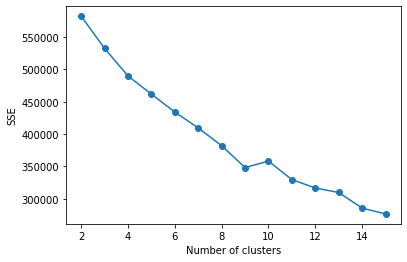

In [74]:
list_SSE = []
list_sil = []
best_inertia = 100000000000
min_k = 2
max_k = 15
range_k = range(min_k, max_k+1)
for i in range_k:
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(scaled)
    list_sil.append(metrics.silhouette_score(scaled, km.labels_))
    list_SSE.append(km.inertia_)
plt.plot(range_k, list_SSE, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

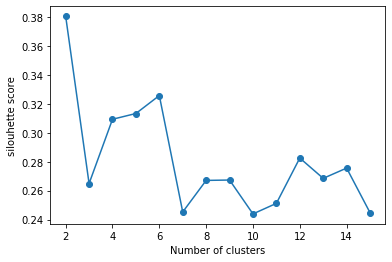

In [75]:
plt.plot(range_k, list_sil, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('silouhette score')
plt.show()

Using the elbow method, it appears that the best number of clusters in k-means is 9. 

In [ ]:
km = KMeans(n_clusters=9, init='random', n_init=10, max_iter=300, tol=1e-04, random_state=0)
km.fit(scaled)
artworks_colours_assigned_kmeans=artworks_colours.assign(label = km.labels_)

###  RESULTS

For both models, the results are mapped by country for the different clusters obtained. To do so, the resulting labels are assigned to each artwork, and the artworks are then grouped by country, keeping the most common label of the artworks of each country. Additionally, as the United-Kingdom is the main country of origin of the TATE collection, the outputs are also grouped and displayed for UK cities. 

####  DBSCAN

From the silhouette scores shown above, it appears that k-means performs on average better than DBscan. The final number of clusters of k-means is also higher than the number of clusters in DBscan. This could be justified by the fact that the data points are all closely clustered: as the colours are percentages, and because of issues of misclassification of colours, the points are likely to be gathered on a small area. Therefore, DBscan is not adequate in forming separate clusters. 

Additionally, the best silhouette score appears when the minimum sample value and the eps values are high. As these parameters will likely reduce the number of clusters, forming larger clusters. The more limited the number of clusters is, the better the silhouette score is, as fewer clusters are less likely to overlap. Therefore, it further confirms the theory that DBscan is not appear  the most appropriate clustering model in this case. This seems to be confirmed by visually checking the maps obtained, as they  only display a limited number of cluster groups. 

In [ ]:
artworks_colours_assigned_cities = artworks_colours_assigned[['cityOfBirth', 'countryOfBirth', 'label']].groupby('cityOfBirth').agg(lambda x:x.value_counts().index[0])
artworks_colours_assigned_countries = artworks_colours_assigned[['cityOfBirth', 'countryOfBirth', 'label']].groupby('countryOfBirth').agg(lambda x:x.value_counts().index[0])

In [ ]:
artworks_colours_assigned_countries = final_countries_df.join(artworks_colours_assigned_countries, on='final_country', how='right')

In [ ]:
fig, ax = plt.subplots(1, figsize=(14,8))
ax = country_names.plot(ax = ax, color='gray')
artworks_colours_assigned_countries.plot(column='label', categorical=True, cmap='YlOrRd', linewidth=.6, edgecolor='0.2',
         legend=True, legend_kwds={'bbox_to_anchor':(0., 0., 0.2, 0.2),'fontsize':8,'frameon':False}, ax=ax)
ax.axis('off')
plt.show()

In [ ]:
artworks_colours_assigned_cities.loc[artworks_colours_assigned_cities['countryOfBirth'] == 'United Kingdom']

In [ ]:
cities = pd.read_csv('world_cities.csv')
cities = cities.drop(columns='Unnamed: 0')
cities

In [ ]:
artworks_colours_assigned_cities = cities.join(artworks_colours_assigned_cities.loc[artworks_colours_assigned_cities['countryOfBirth'] == 'United Kingdom'], on='name', how='inner')

In [ ]:
geom = [Point(xy) for xy in zip(artworks_colours_assigned_cities['lon'], artworks_colours_assigned_cities['lat'])]
gdf_UK_art_cities = gpd.GeoDataFrame(artworks_colours_assigned_cities, geometry=geom)
gdf_UK_art_cities

In [ ]:
UK = country_names.loc[country_names['ADMIN'] == 'United Kingdom']

In [ ]:
mapping_dict = {-1: 'black',
                    0: 'pink', 
                  1: 'mediumorchid', 
                  2: 'mediumblue', 
                  3: 'paleturquoise', 
                  4: 'limegreen', 
                  5: 'yellow', 
                  6: 'orange', 
                  7: 'orangered', 
                  8: 'lightcoral', 
                  9: 'gray'
                 }

In [ ]:
gdf_UK_art_cities['map_col'] = gdf_UK_art_cities['label'].map(mapping_dict)

In [ ]:
gdf_UK_art_cities = gdf_UK_art_cities.loc[gdf_UK_art_cities['country_cd']=='GB']

This observation mentioned above is even more obvious when looking at United Kingdom cities. In this figure, only two categories appear: -1, which reflects the points assigned as ‘noise’ by DBscan, and the category 0. 

In [ ]:
fig, ax = plt.subplots(figsize=(30,15))
UK.plot(ax=ax, color='white', edgecolor='grey')
plt.title(f'dbscan groups')
for i in range(0, gdf_UK_art_cities.shape[0]):
    gdf_UK_art_cities.iloc[i:i+1].plot(ax=ax, color=gdf_UK_art_cities['map_col'].iloc[i], markersize= 60, legend=True, alpha=0.6)
legend_elements = [Line2D([0], [0], marker='o', color=mapping_dict[i], label=f'group {i}')for i in np.unique(gdf_UK_art_cities['label'].values)]

ax.legend(handles=legend_elements)

plt.show()

Looking at tall cluster groups of DBscan globally, the previous assumptions appear correct: a majority of the data points was either considered as noise (about 12%) or assigned to the first group (86%). Therefore, the data is mostly contained in one large cluster, or considered as not belonging to any, which does not appear as a realistic behaviour. All the above observation lead to the conclusion that  DBscan is not the most appropriate model for this study’s purpose.


In [ ]:
total = artworks_colours_assigned.shape[0]
for i in np.unique(artworks_colours_assigned['label'].values):
    nb = artworks_colours_assigned.loc[artworks_colours_assigned['label']==i].shape[0]
    print(f'There are {nb} instances of the category {i} out of the {total} rows of the dataset, so about {int(100*nb/total)} percent')

#### K-MEANS 

Therefore, k-means emerges as the best clustering methodology in this context. The silhouette scores obtained with k-means clustering are higher than the scores of DBscan, while conserving a higher number of clusters. This value gives a silhouette score of about 0.268. 

Additionally, the distribution of the clusters appears less extreme and therefore more relevant.

In [ ]:
total = artworks_colours_assigned_kmeans.shape[0]
for i in np.unique(artworks_colours_assigned_kmeans['label'].values):
    nb = artworks_colours_assigned_kmeans.loc[artworks_colours_assigned_kmeans['label']==i].shape[0]
    print(f'Wit hthe k-means model, there are {nb} instances of the category {i} out of the {total} rows of the dataset, so about {int(100*nb/total)} percent')


In [ ]:
artworks_colours_assigned_kmeans_cities = artworks_colours_assigned_kmeans[['cityOfBirth', 'countryOfBirth', 'label']].groupby('cityOfBirth').agg(lambda x:x.value_counts().index[0])
artworks_colours_assigned_kmeans_countries = artworks_colours_assigned_kmeans[['cityOfBirth', 'countryOfBirth', 'label']].groupby('countryOfBirth').agg(lambda x:x.value_counts().index[0])

In [ ]:
artworks_colours_assigned_kmeans_countries = final_countries_df.join(artworks_colours_assigned_kmeans_countries, on='final_country', how='right')

Despite this, the maps of the clusters by country does not reveal any obvious pattern. 

In [ ]:
fig, ax = plt.subplots(1, figsize=(14,8))
ax = country_names.plot(ax = ax, color='gray')
artworks_colours_assigned_kmeans_countries.plot(column='label', categorical=True, cmap='YlOrRd', linewidth=.6, edgecolor='0.2',
         legend=True, legend_kwds={'bbox_to_anchor':(0., 0., 0.2, 0.2),'fontsize':8,'frameon':False}, ax=ax)
ax.axis('off')
plt.show()

In [ ]:
artworks_colours_assigned_kmeans_cities = cities.join(artworks_colours_assigned_kmeans_cities.loc[artworks_colours_assigned_kmeans_cities['countryOfBirth'] == 'United Kingdom'], on='name', how='inner')
geom = [Point(xy) for xy in zip(artworks_colours_assigned_kmeans_cities['lon'], artworks_colours_assigned_kmeans_cities['lat'])]
gdf_UK_art_cities_kmeans = gpd.GeoDataFrame(artworks_colours_assigned_kmeans_cities, geometry=geom)
gdf_UK_art_cities_kmeans

In [ ]:
mapping_colours= {0: 'pink', 
                  1: 'mediumorchid', 
                  2: 'mediumblue', 
                  3: 'paleturquoise', 
                  4: 'limegreen', 
                  5: 'yellow', 
                  6: 'orange', 
                  7: 'orangered', 
                  8: 'lightcoral', 
                  9: 'gray',
                 10: 'black'}

In [ ]:
gdf_UK_art_cities_kmeans['map_col'] = gdf_UK_art_cities_kmeans['label'].map(mapping_colours)

In [ ]:
gdf_UK_art_cities_kmeans = gdf_UK_art_cities_kmeans.loc[gdf_UK_art_cities_kmeans['country_cd'] == 'GB']

Looking at the map of the clusters by UK city, more clusters appear.

In [ ]:
fig, ax = plt.subplots(figsize=(30,15))
UK.plot(ax=ax, color='white', edgecolor='grey')
plt.title(f'kmeans groups')
for i in range(0, gdf_UK_art_cities_kmeans.shape[0]):
    gdf_UK_art_cities_kmeans.iloc[i:i+1].plot(ax=ax, color=gdf_UK_art_cities_kmeans['map_col'].iloc[i], markersize= 60, legend=True, alpha=0.6)
legend_elements = [Line2D([0], [0], marker='o', color=mapping_colours[i], label=f'group {i}')for i in np.unique(gdf_UK_art_cities_kmeans['label'].values)]

ax.legend(handles=legend_elements)
plt.show()

In order to have a clearer view of the cluster patterns, separate maps were generated for each cluster. Because k-means clustering depends on the randomly placed initial cluster centroids, the same model can provide different outputs. Therefore, the maps of the UK clusters used for this analysis were saved and are displayed by running the code below.


Some observations can be made from these maps. Firstly, cluster 0 seems to have no city in the country, most of the cities in this cluster are located on, or near the coast. Additionally, while most clusters seem homogeneously spread through space, cities in cluster 5 appear to be gathered around specific centers. It therefore seems that some behaviours might be suggested by the analysis. 

In [ ]:
fig, ax = plt.subplots(5,2, figsize=(20,60))
ax = ax.ravel()
for i in range(10):
    UK.plot(ax=ax[i], color='white', edgecolor='grey')
    ax[i] = gdf_UK_art_cities_kmeans.loc[gdf_UK_art_cities_kmeans['label']==i].plot(ax=ax[i], color=mapping_colours[i])
    
    ax[i].set_title(f'kmeans group {i} for UK cities ')
plt.show()

In [ ]:
clusters_uk_img = Image.open('all_clusters_maps_uk.png')
clusters_uk_img.show()

However, despite this slight increase in the coherence of the results, the low silhouette score and the lack of clear emerging pattern does not allow us to arrive at any conclusion.

### LIMITATIONS AND POTENTIAL SOLUTIONS FOR FUTURE RESEARCH

Therefore, although k-means offers better results than DBscan, it still does not appear enough to observe significant patterns. Several strategies should be attempted in future research to investigate further. First, due to the time constraints of this project, finding more datasets and standardising them to enable analysis was not undertaken. However,
datasets including more data from different countries and regions should be used in order to obtain more reliable and statistically significant data, especially for non-western countries. 


Secondly, another colour classification method could be attempted. RGB is the most common colour coding methodology, but others can be used, such as HSV (hue saturation value), which is closer to the human eye’s perception of colour.
Additionally, as artistic movements and technological knowledge evolve with time, further analysis could consider specific time periods separately. In the TATE dataset, the lack of data from varied time periods made impossible such an analysis.
Lastly, with better performing machines and a longer timeframe, other clustering methodologies should be attempted, such as hierarchical clustering. 


###  CONCLUSION

This analysis used the TATE dataset to study colour use in different regions of the world. After downloading all images of the dataset, the colour distribution of each image was computed. DBscan and k-means clustering models were applied onto the data, and the best parameters were selected from fitting each model with different sets of hyperparameters. The results were then grouped by city and country and plotted. However, although k-means outperformed DBscan, no obvious pattern appeared in the outputs of the models. Several theories can explain this observation, from the limitation of the initial data, to the colour detection to the models used. Suggestions for further analysis are made, which would allow to decide whether this lack of pattern is due to data or methodology limitations, or to an actual absence of pattern. 

###  BIBLIOGRAPHY

Adams, F. M., & Osgood, C. E. (1973). A Cross-Cultural Study of the Affective Meanings of Color. Journal of Cross-Cultural Psychology, 4(2), 135–156. https://doi.org/10.1177/002202217300400201

Ball, P. (2016). Material witness: None more black. Nature Materials, 15(5), 500. doi:http://dx.doi.org.libproxy.ucl.ac.uk/10.1038/nmat4633

Best, Janet. (2017). Colour Design - Theories and Applications (2nd Edition) - 20. Colour in Culture: Shifting Values, Understanding and Functions. Elsevier. Retrieved from
https://app.knovel.com/hotlink/pdf/id:kt011G8KN1/colour-design-theories/colour-in-culture-shifting

Kriegel, H. P., Schubert, E., & Zimek, A. (2017). The (black) art of runtime evaluation: Are we comparing algorithms or implementations? Knowledge and Information Systems, 52(2), 341-378 http://rdcu.be/uHkO

Mather, G. (2013). Colour in art. In The Psychology of Visual Art: Eye, Brain and Art (pp. 109-121). Cambridge: Cambridge University Press. doi:10.1017/CBO9781139030410.008
 
TATE. (2014). Tategallery/Collection. [online] GitHub. Available at: <https://github.com/tategallery/collection> [Accessed 6 February 2020].